# Problem 1: Clustering
A leading bank wants to develop a customer segmentation to give promotional offers to its customers.
They collected a sample that summarizes the activities of users during the past few months.
You are given the task to identify the segments based on credit card usage.

In [484]:
# importing basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [485]:
df1=pd.read_csv("bank_marketing_part1_Data-1.csv") # Loading the .csv file of the dataset

In [486]:
df1.head() # Top five records of the dataset

spending  advance_payments  probability_of_full_payment  current_balance  \
0     19.94             16.92                       0.8752            6.675   
1     15.99             14.89                       0.9064            5.363   
2     18.95             16.42                       0.8829            6.248   
3     10.83             12.96                       0.8099            5.278   
4     17.99             15.86                       0.8992            5.890   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  
0         3.763            3.252                         6.550  
1         3.582            3.336                         5.144  
2         3.755            3.368                         6.148  
3         2.641            5.182                         5.185  
4         3.694            2.068                         5.837

In [487]:
df1.shape

(210, 7)

The dataset loaded correctly and has 210 rows and 7 columns or variables and these seem to be all numeric

## 1.1 Read the data and do exploratory data analysis. Describe the data briefly.

In [488]:
df1.describe().T 

count       mean       std      min       25%  \
spending                      210.0  14.847524  2.909699  10.5900  12.27000   
advance_payments              210.0  14.559286  1.305959  12.4100  13.45000   
probability_of_full_payment   210.0   0.870999  0.023629   0.8081   0.85690   
current_balance               210.0   5.628533  0.443063   4.8990   5.26225   
credit_limit                  210.0   3.258605  0.377714   2.6300   2.94400   
min_payment_amt               210.0   3.700201  1.503557   0.7651   2.56150   
max_spent_in_single_shopping  210.0   5.408071  0.491480   4.5190   5.04500   

                                   50%        75%      max  
spending                      14.35500  17.305000  21.1800  
advance_payments              14.32000  15.715000  17.2500  
probability_of_full_payment    0.87345   0.887775   0.9183  
current_balance                5.52350   5.979750   6.6750  
credit_limit                   3.23700   3.561750   4.0330  
min_payment_amt                3.59900   4.768750   8.4560  
max_spent_in_single_shopping   5.22300   5.877000   6.5500

There's not a major difference #between the 75th percentile and the maximum value for all the variables. 
Nevertheless, we will check for outliers by making box plots.

In [489]:
# Are there any missing values ?
df1.isna().sum()

spending                        0
advance_payments                0
probability_of_full_payment     0
current_balance                 0
credit_limit                    0
min_payment_amt                 0
max_spent_in_single_shopping    0
dtype: int64

There are no missing values

In [490]:
# Data types
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


All the seven variables are numeric, of data type float.
This meets the basic requirement for the clustering algorithms that we'd like use for customer segmentation.

In [491]:
# Are there any duplicates ?
dups = df1.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
df1[dups]

Number of duplicate rows = 0


Empty DataFrame
Columns: [spending, advance_payments, probability_of_full_payment, current_balance, credit_limit, min_payment_amt, max_spent_in_single_shopping]
Index: []

There are no Duplicates or missing values

In [492]:
# Checking for outliers

In [493]:
def boxplot_comparison(df, hue=None): # This user-defined function makes boxplots
    """Given dataframe, generate boxplots of numeric data"""
    print("\nTo check: \nPresence of outliers")

    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()


To check: 
Presence of outliers


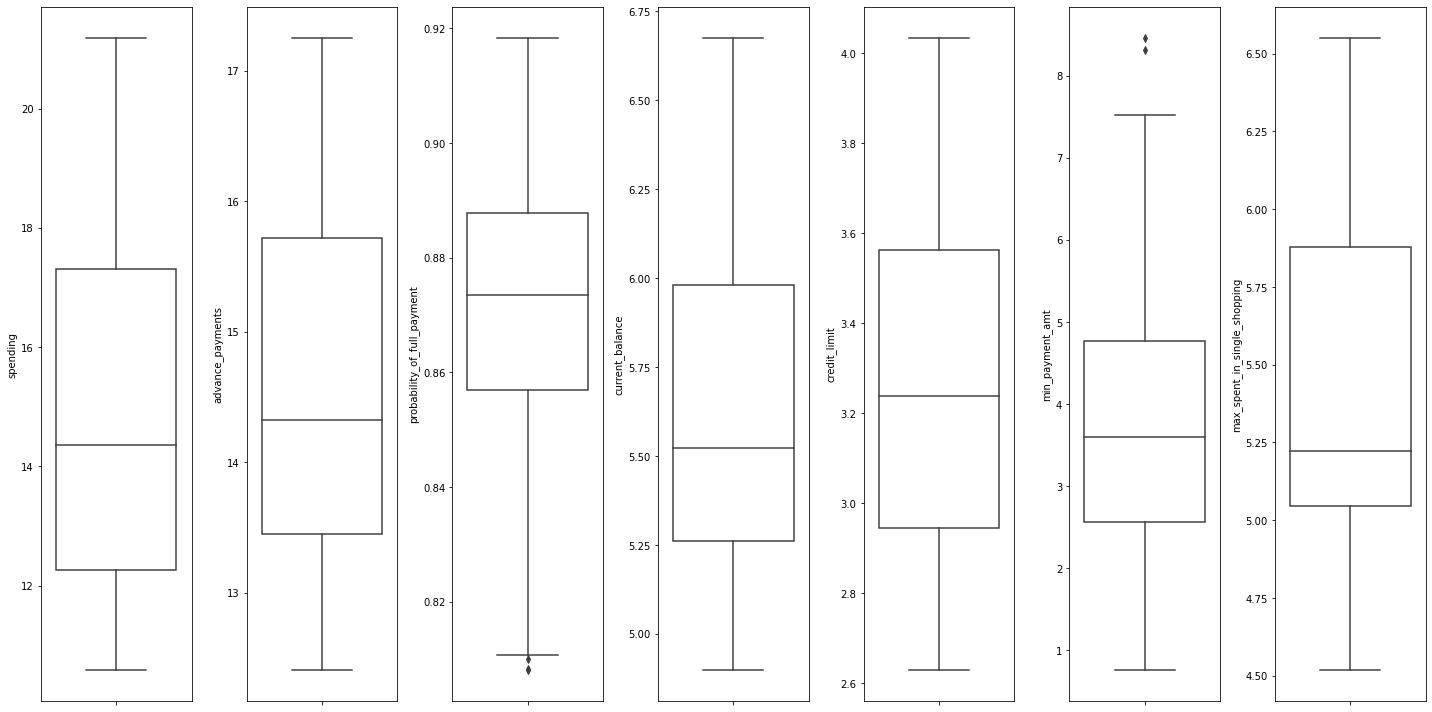

In [494]:
boxplot_comparison(df1)

For clustering only numeric columns are used.
The outliers are points that do not meet distance and minimum samples requirements to be recognised as a cluster
The dataset has a very small number of outliers, which we can replace with the upper or the lower limit

In [495]:
def remove_outlier(col): # This user-defined function is for removing outliers and marks the lower and upper ranges
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [496]:
df1.columns

Index(['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping'],
      dtype='object')

In [497]:
# The outliers are treated with the minimum and maximum value of inter-quartile range or IQR. 
# The outliers beyond the third quartile or Q3 are replaced with the upper limit.
# The outliers below the first quartile or Q1 are replaced with the lower limit

l1,u1=remove_outlier(df1['probability_of_full_payment'])
df1['probability_of_full_payment']=np.where(df1['probability_of_full_payment']>u1,u1,df1['probability_of_full_payment'])
df1['probability_of_full_payment']=np.where(df1['probability_of_full_payment']<l1,l1,df1['probability_of_full_payment'])

l2,u2=remove_outlier(df1['min_payment_amt'])
df1['min_payment_amt']=np.where(df1['min_payment_amt']>u2,u2,df1['min_payment_amt'])
df1['min_payment_amt']=np.where(df1['min_payment_amt']<l2,l2,df1['min_payment_amt'])


To check: 
Presence of outliers


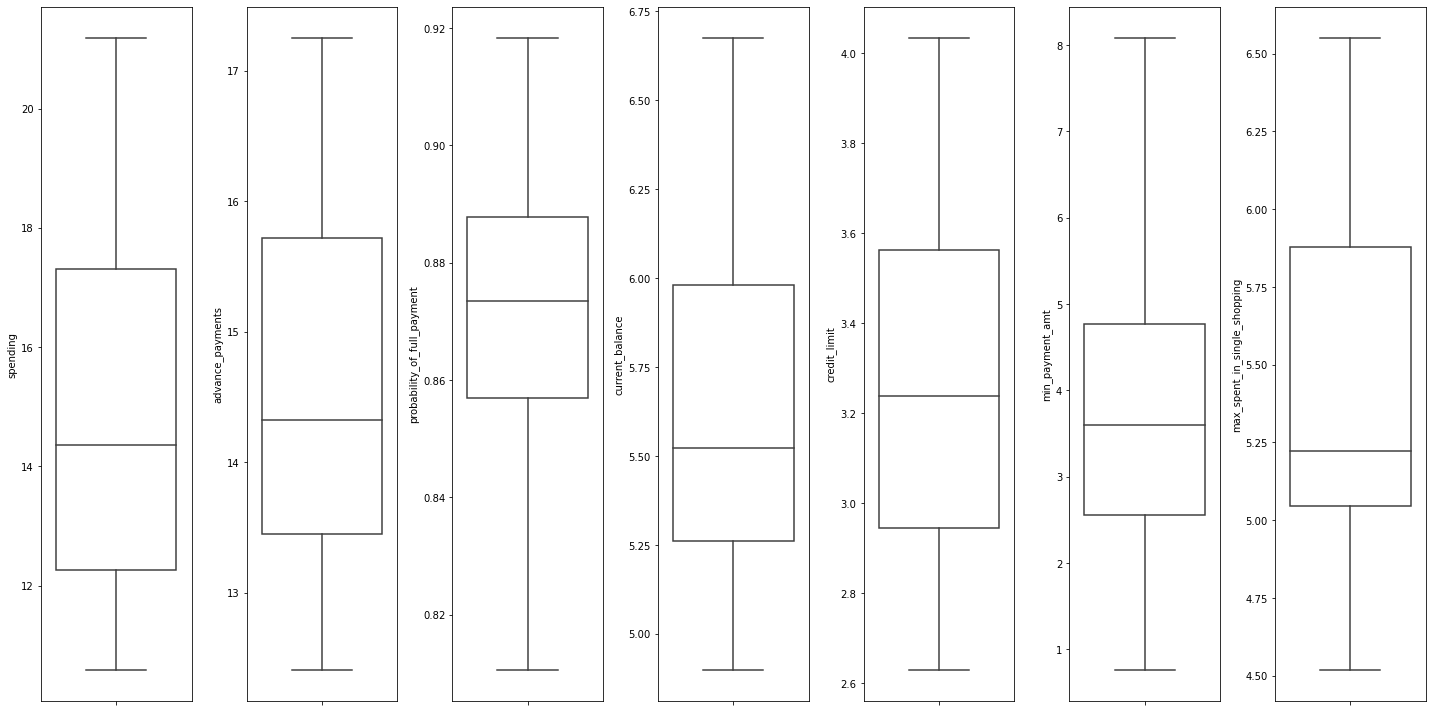

In [498]:
boxplot_comparison(df1) # Second look after outlier treatment

All outliers removed. These were in the lower range of the variable 'probability_of_full_payment'
and the upper range of 'min_payment_amt'

In [499]:
# Further numeric EDA

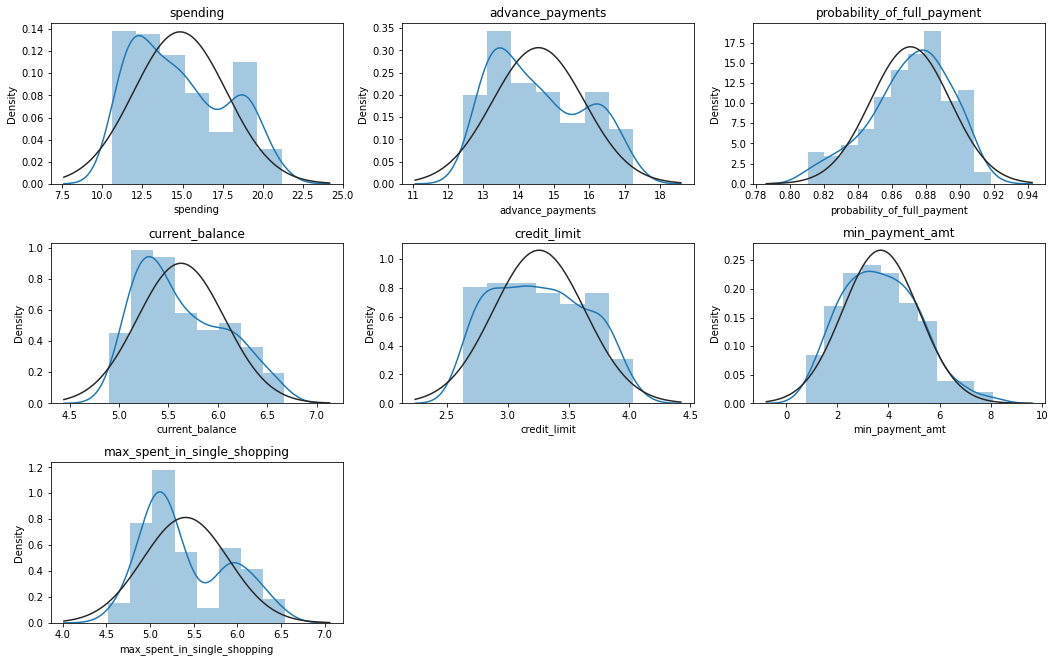

In [500]:
# A quick check on the variables

from scipy.stats import norm 

graph_by_variables = ['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping']
plt.figure(figsize=(15,18))

for i in range(0,7):
    plt.subplot(6,3,i+1)
    sns.distplot(df1[graph_by_variables[i]].dropna(),fit=norm)
    plt.title(graph_by_variables[i])

plt.tight_layout()

None of the variables has perfect normal distribution. 
Most of the variabels are right skewed, while 'probability_of_full_payment' is left-skewed.
In a left skewed distribution, the mean is less than the median. 
In a right skewed distribution, the mean is greater than the median. 
In a symmetrical or normal distribution, the mean, median, and mode are all equal.
Symmetrical distributions are indicated by the black curve for reference, while the actual distribution curves are in blue.
A distribution is left skewed if it has a “tail” on the left side of the distribution. 
A distribution is right skewed if it has a “tail” on the right side of the distribution.

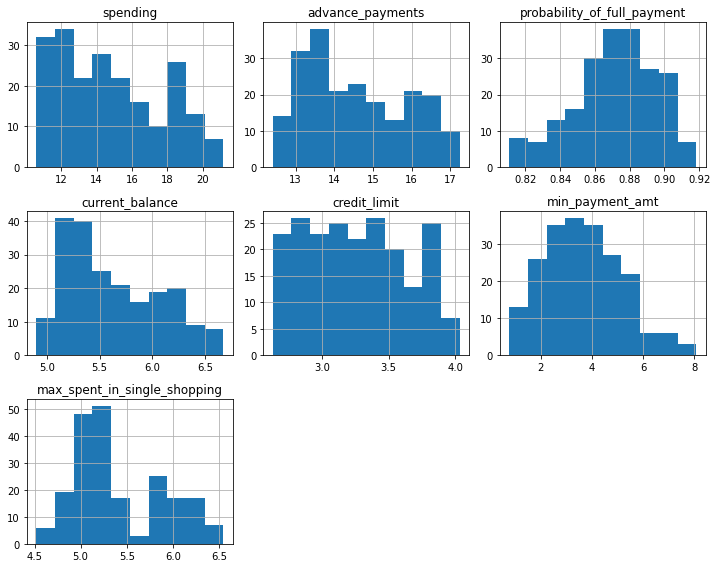

In [501]:
#Frequency variables in charts

df1[['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping']].hist(figsize=(10,8))
plt.tight_layout()

We start by looking at the horizontal or x-axis of these histograms to see how the data in each variable is grouped. 
Then, we look at the vertical or y-axis to see how frequently that data occurs.
Bar charts and histograms are similar but with some very specific differences. 
A bar chart groups numbers into categories, while histograms group numbers into ranges. 
Histograms are used to show the results of continuous data, generally.
The spending range of up to 12(k or anything) rupees/dollars (or anything) has the highest number of customers (32+34=66).
The highest number of customers for any advance payment range is 38 for between 13(k) and 14(k). 
There's nearabout 88% probability of full payment for 78 customers (39+39), which is the highest. 
82 customers have have current balance between 5.1 and 5.4. 
The credit limit is most uniform across ranges, except when it touches 4. 
Understandable, as higher credit limit is only for a few. 
37 customers (the most for any range) have minimum payment amount around 3. 
100 customers (the most for any range) have spent between 5 and 5.3 on their biggest single shopping trips. 
Maybe they charged higher-value products on credit card for which cash payment isn't the preferred mode of transaction.

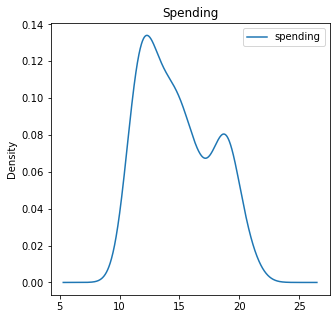

In [502]:
# A look at spending

df1[['spending']].plot.kde(figsize=(5,5),title='Spending');

Spending density is the maximum for 10 to 15 cost range. 
The wave picks up around 7 and dies out after touching the shores of 23.
A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset.
This is analagous to a histogram. 
KDE represents the data using a continuous probability density curve in one or more dimensions.
It depicts the probability density at different values in a continuous variable.
The density curve for spending in this case has two distinct peaks, indicating that the distribution is bimodal.

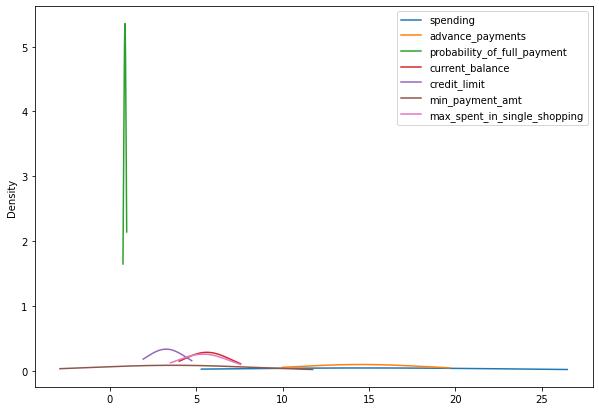

In [503]:
# Multivariate density plot
ax = df1[['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping']].plot.kde(figsize=(10,7), bw_method=3) #,ind=[0, 2, 3,4]

The KDE algorithm takes a parameter, bandwidth, that affects how “smooth” the resulting curve is.
The KDE is calculated by weighting the distances of all the data points we’ve seen for each location on the blue line.
If we’ve seen more points nearby, the estimate is higher, indicating that probability of seeing a point at that location.
The density curve for probability of full payment has very low bandwidth and very high amplidude (almost 5 or 6 times).
This means the probability of seeing a data point at that location is very slim. Not many people will ever make full payment.
This is true, as there is never 100% surety of it.

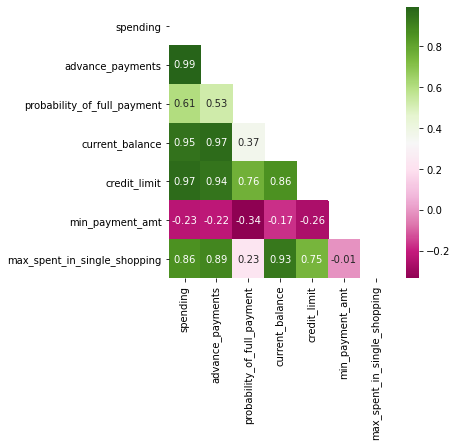

In [504]:
# Studying correlation by heatmap
fig, ax = plt.subplots(figsize=(5, 5))
mask = np.zeros_like(df1.corr())
mask[np.triu_indices_from(mask)] = 1
g=sns.heatmap(df1.corr(),annot=True, fmt=".2f", mask=mask, ax=ax, cmap="PiYG");
# g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')

Advance payments have a high correlation with spending, credit balance and credit limit. 
Maximum spending in single shopping has a high correletion with current balance. 
Minimum payment amount has a negative correlation with spending, probablity of full payment, current balance, credit limit and advance payments (Notice the purple strip)

In [505]:
#Further EDA
# Plot the pairwise joint distributions
def numeric_eda(df, hue=None):
    """Given dataframe, generate pairplot of numeric data"""
    print("\nTo check: \nPairwise relationships in dataset")

    if hue==None:
        sns.pairplot(df.select_dtypes(include=np.number))
    else:
        sns.pairplot(df.select_dtypes(include=np.number).join(df[[hue]]), hue=hue)
    plt.show()


To check: 
Pairwise relationships in dataset


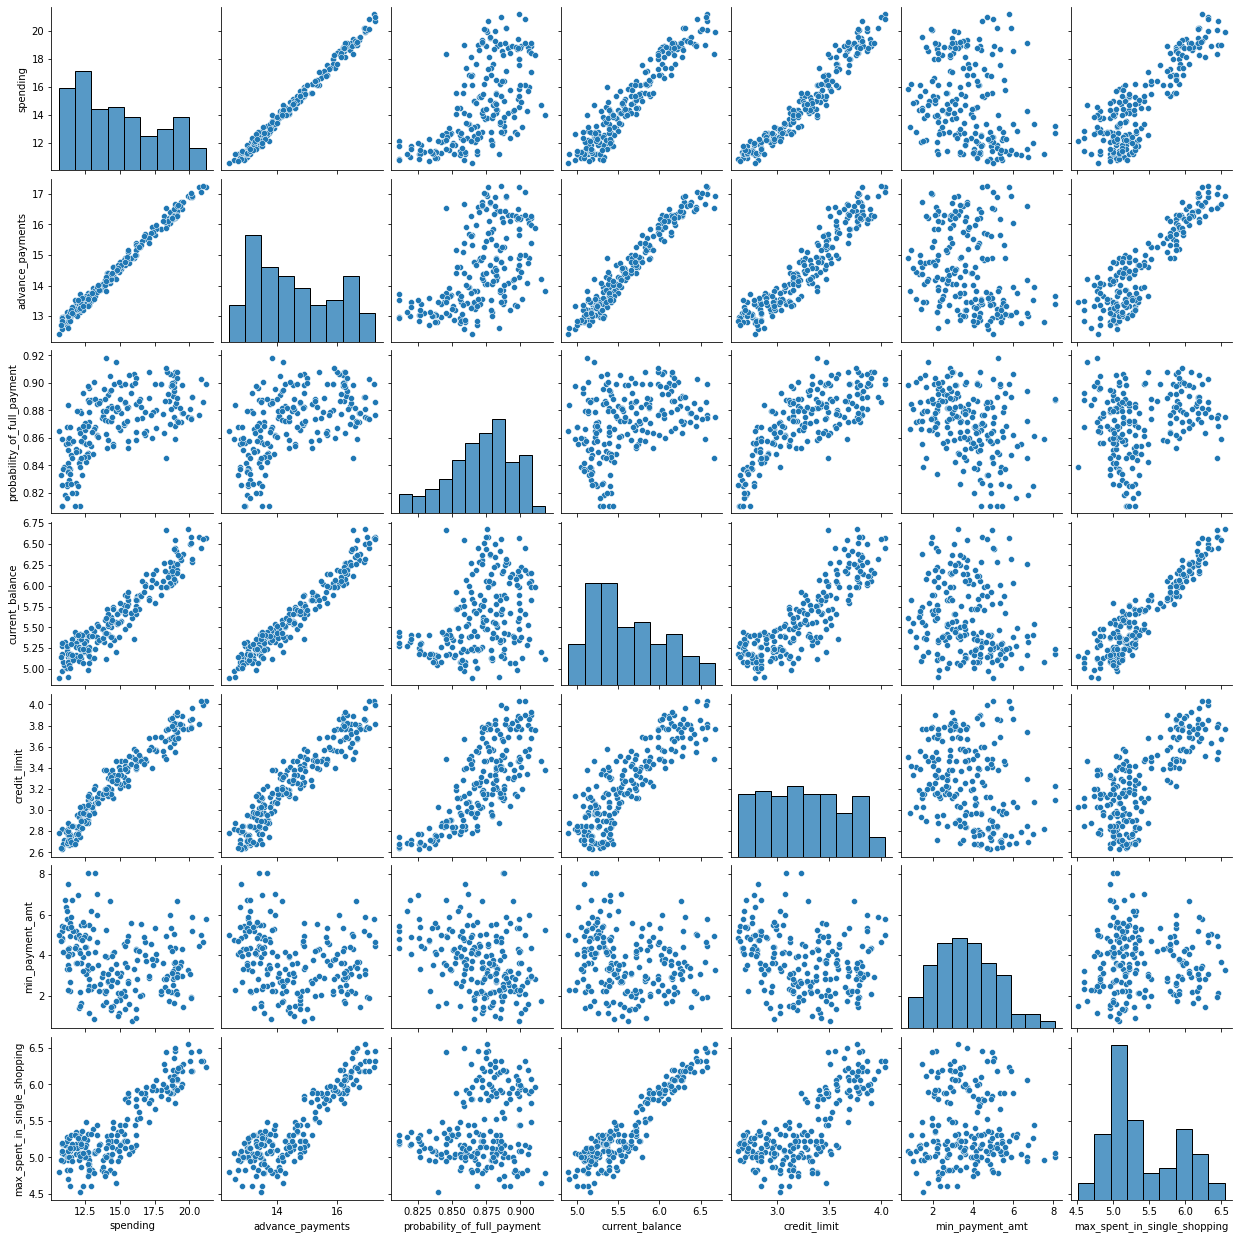

In [506]:
numeric_eda(df1)

There are quite a few instances of strong, linear correlation between variables, such as between spending and advance payments; advance payment and current balance; spending and credit limit; current balance and maximum spent in single shopping etc.

In [507]:
# Hued pairplots

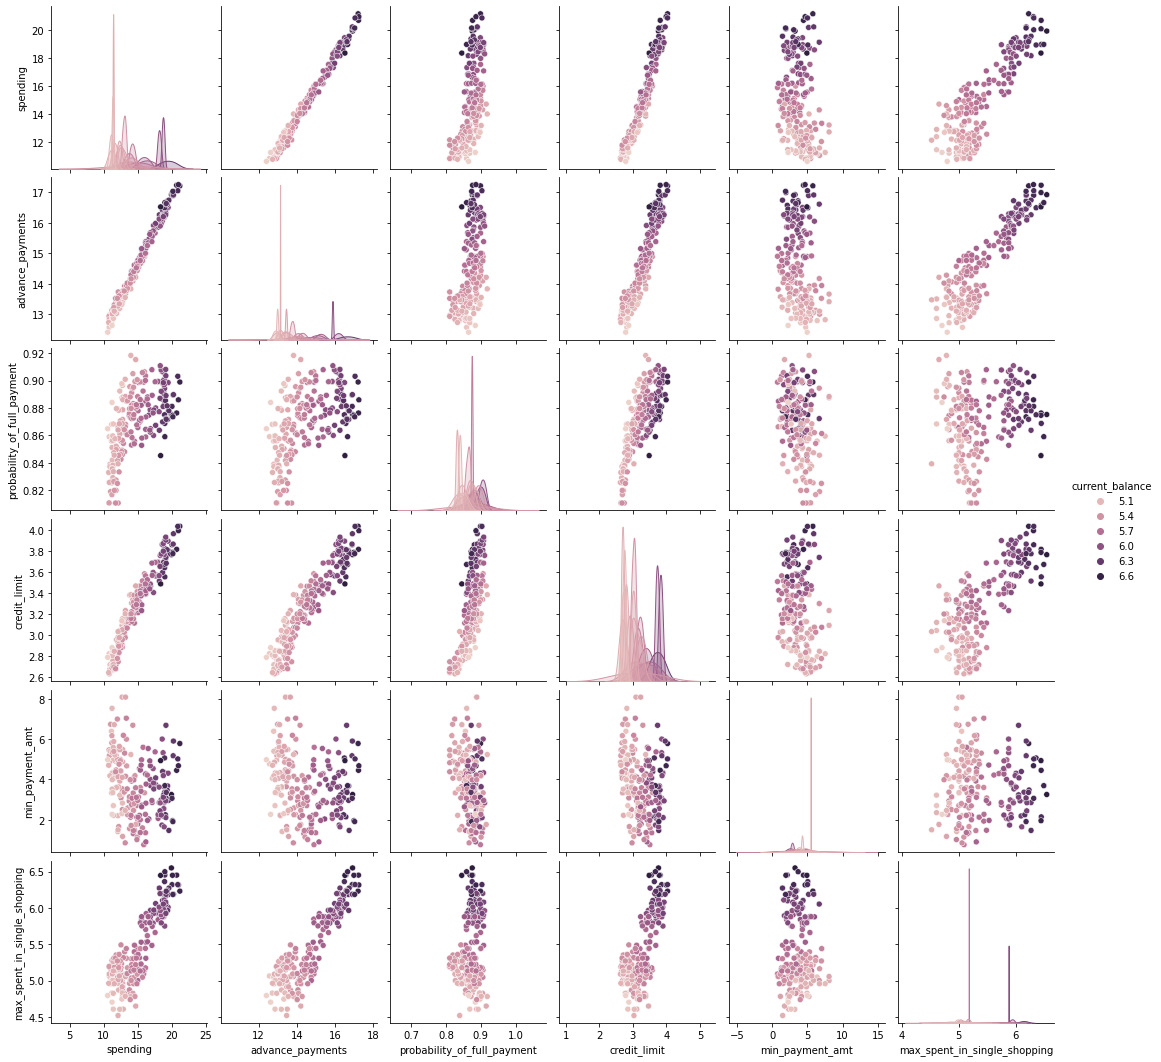

In [508]:
sns.pairplot(df1, hue='current_balance');

Current balance has six distinct groups. See legend.

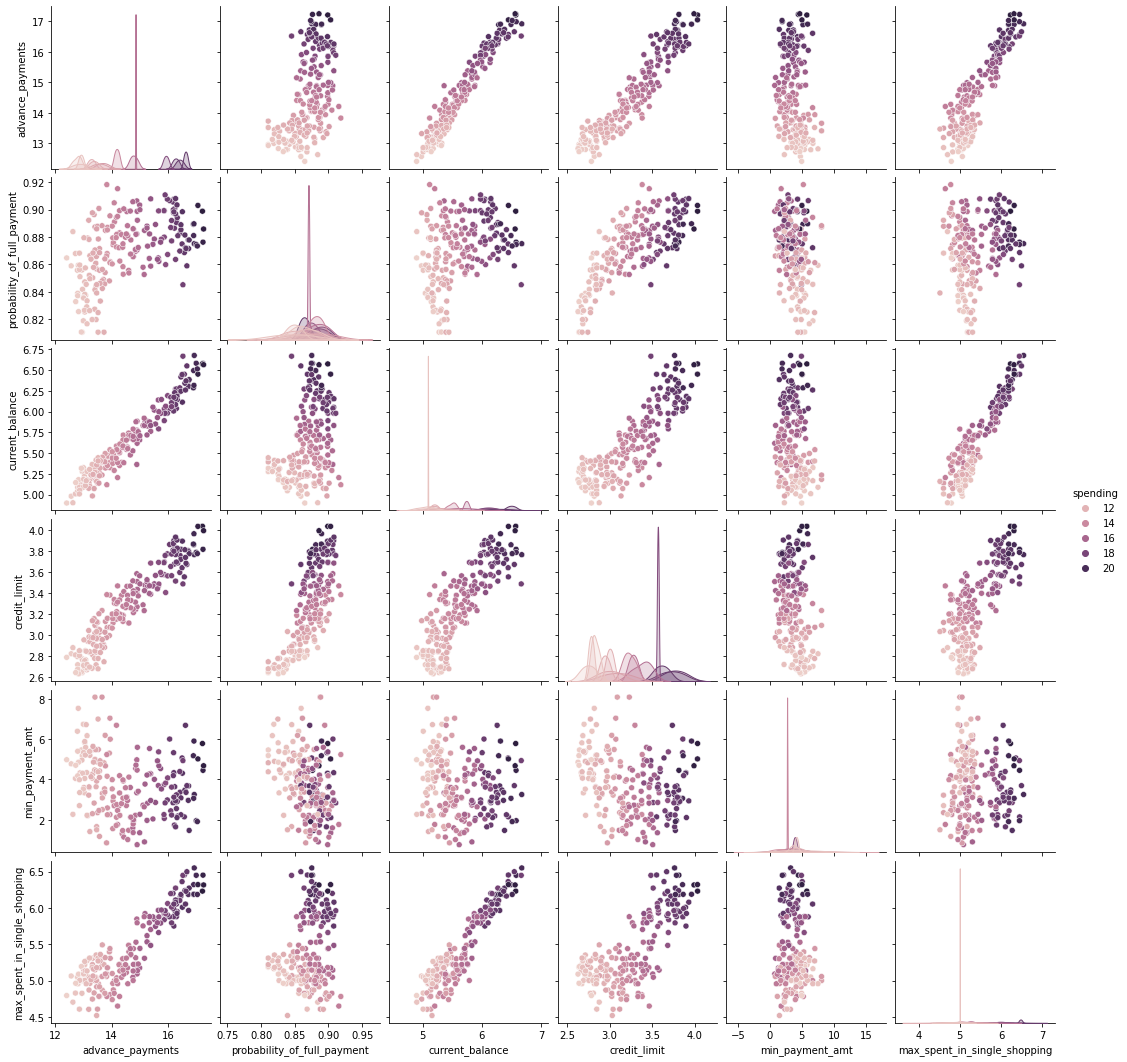

In [509]:
sns.pairplot(df1, hue='spending');

Spending has five distinct groups. See legend.

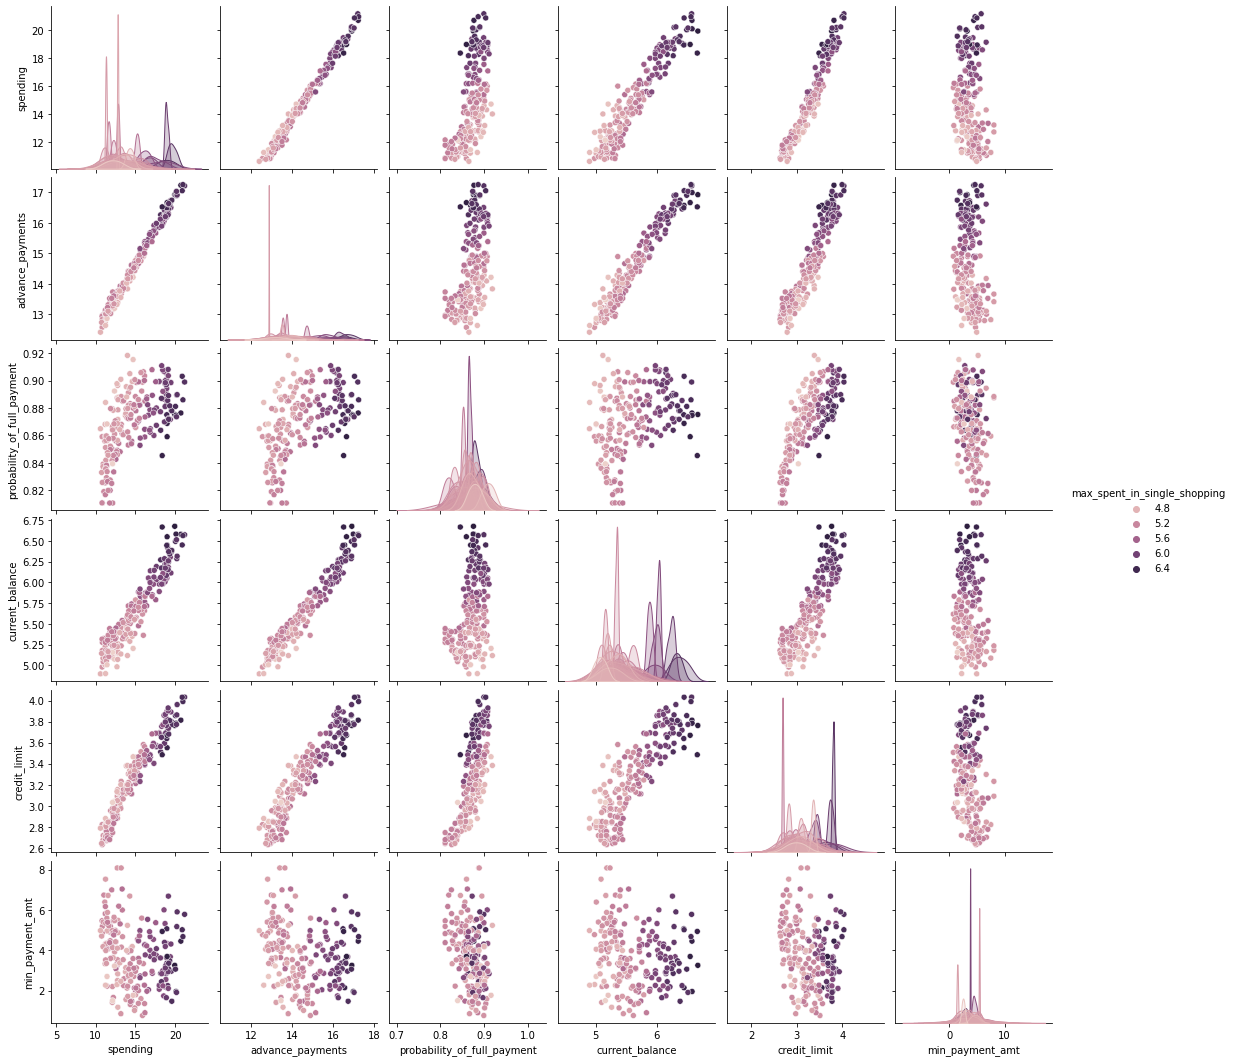

In [510]:
sns.pairplot(df1, hue='max_spent_in_single_shopping');

Maximum spend in single shopping has five distinct groups. See legend.

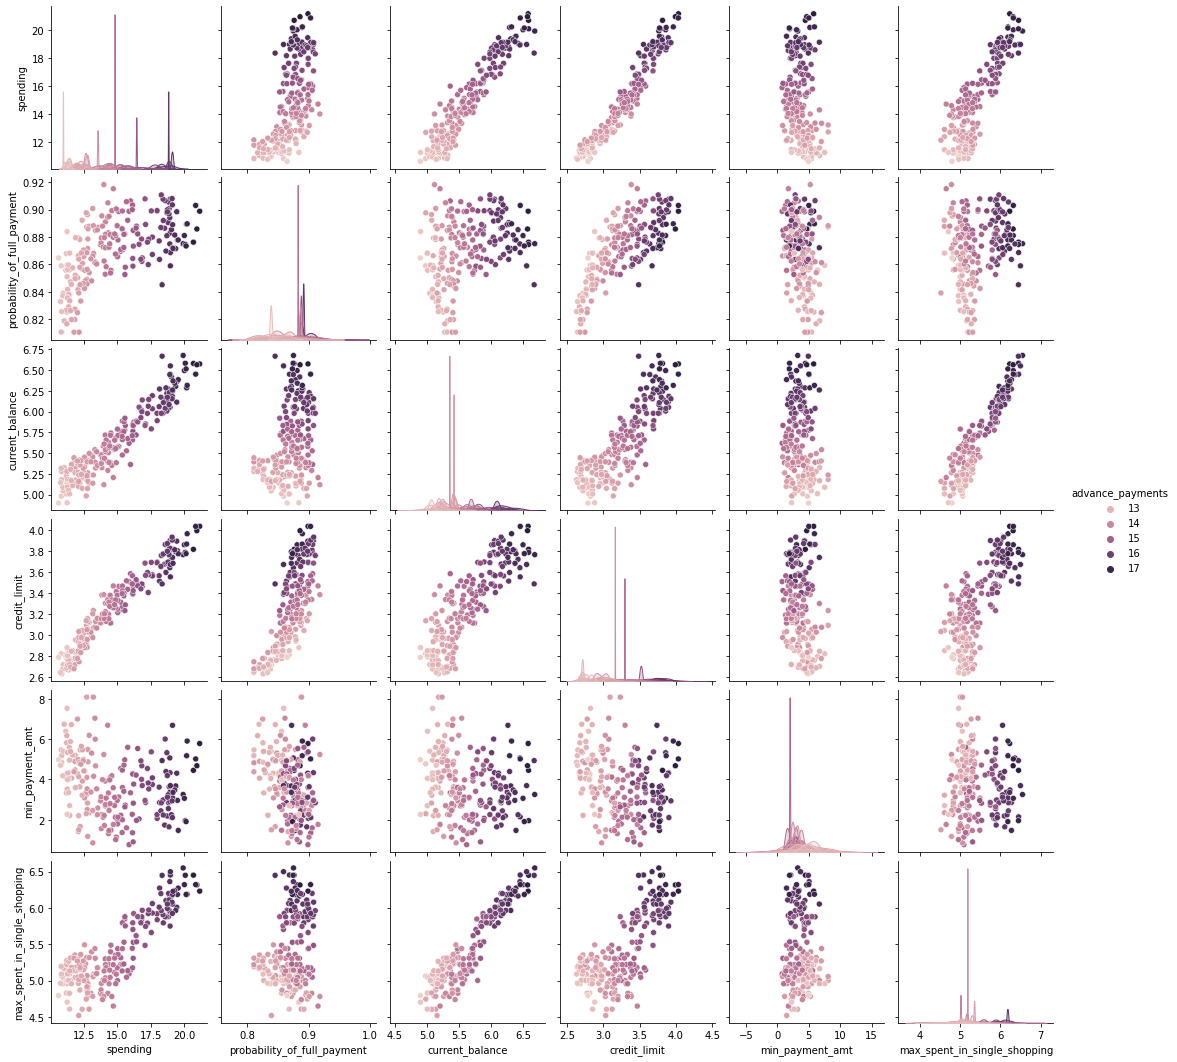

In [511]:
sns.pairplot(df1, hue='advance_payments');

Advance payment has five distinct groups. See legend.

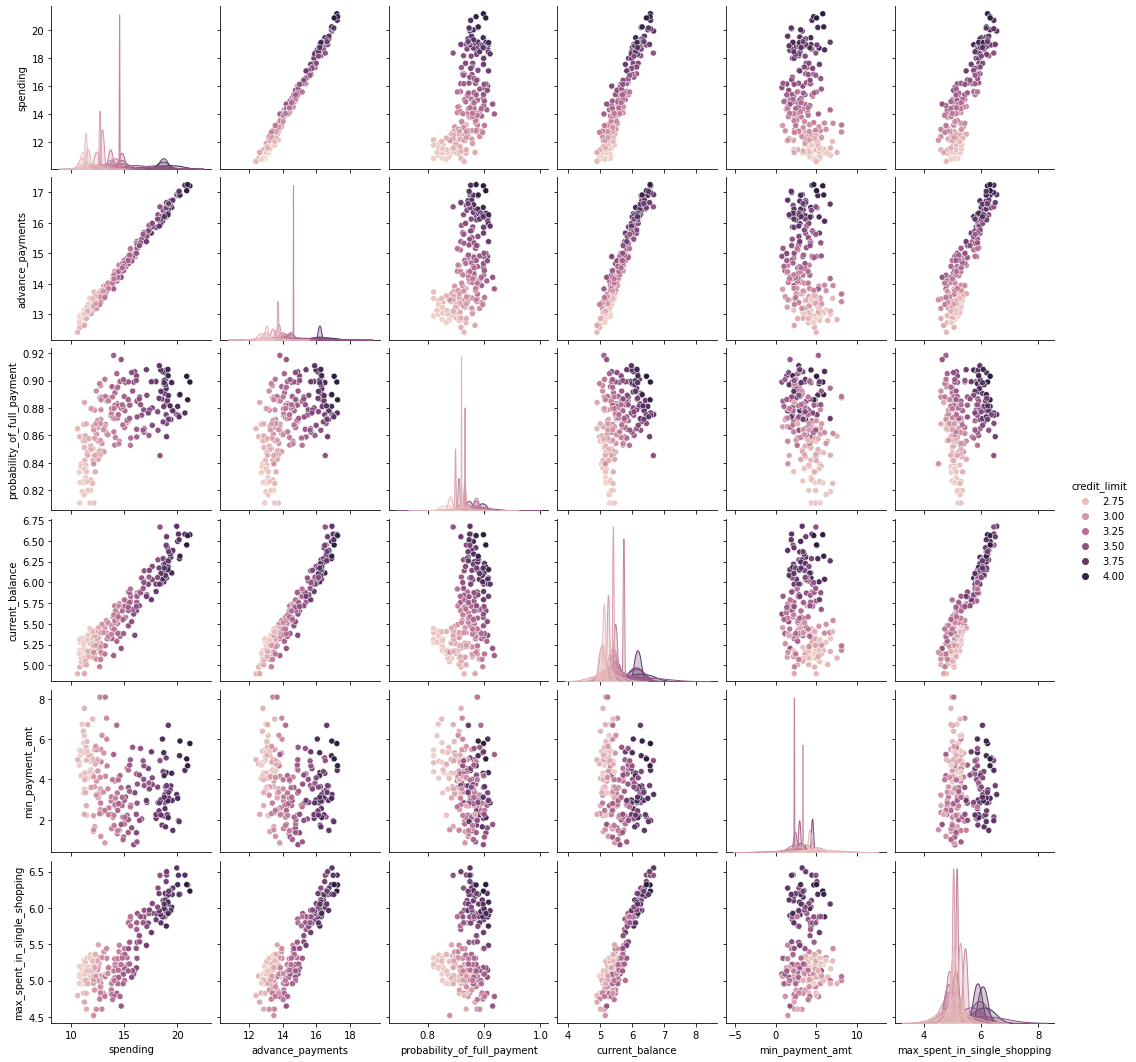

In [512]:
sns.pairplot(df1, hue='credit_limit');

Credit limit has six distinct groups. See legend.

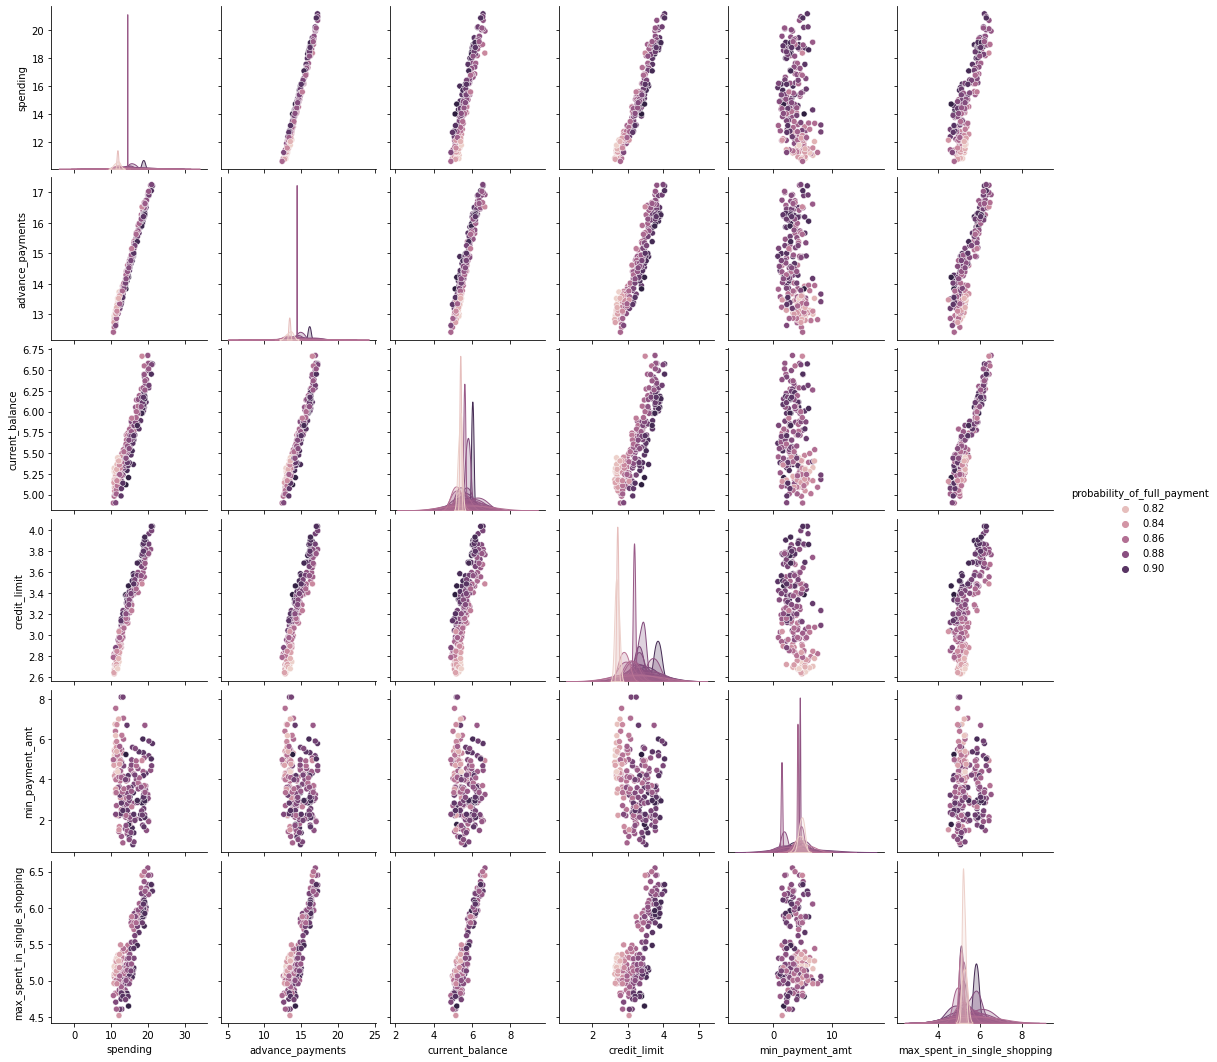

In [513]:
sns.pairplot(df1, hue='probability_of_full_payment');

Probability of full payment has five distinct groups. See legend.

In [514]:
# Function for variable description (five-number summary)

def univariateAnalysis_numeric(column,nbins):
    print('')
    print('')
    print("Description of " + column)
    print("----------------------------------------------------------------------------")
    print(df1[column].describe(),end=' ')
    

df_num = df1.select_dtypes(include = ['float64', 'int64'])
lstnumericcolumns = list(df_num.columns.values)
len(lstnumericcolumns)

for x in lstnumericcolumns:
    univariateAnalysis_numeric(x,20)



Description of spending
----------------------------------------------------------------------------
count    210.000000
mean      14.847524
std        2.909699
min       10.590000
25%       12.270000
50%       14.355000
75%       17.305000
max       21.180000
Name: spending, dtype: float64 

Description of advance_payments
----------------------------------------------------------------------------
count    210.000000
mean      14.559286
std        1.305959
min       12.410000
25%       13.450000
50%       14.320000
75%       15.715000
max       17.250000
Name: advance_payments, dtype: float64 

Description of probability_of_full_payment
----------------------------------------------------------------------------
count    210.000000
mean       0.871025
std        0.023560
min        0.810588
25%        0.856900
50%        0.873450
75%        0.887775
max        0.918300
Name: probability_of_full_payment, dtype: float64 

Description of current_balance
-------------------------------

## 1.2 Do you think scaling is necessary for clustering in this case? Justify.

We do have to use scaling, since hierarichal clustering and Kmeans both use distance-based algorithms for computation. Moreover, the data also has a few variables on different scales. For example,
probability of full payment is on a scale of 10^(-4), while spending is on a hundredth scale. Thereforce, it become necessary to scale the data. We used zscaling, because the variance between the columns is more or less the same.

In [515]:
from scipy.stats import zscore

In [516]:
df_std = df1.apply(zscore)

In [517]:
df_std.head()

spending  advance_payments  probability_of_full_payment  current_balance  \
0  1.754355          1.811968                     0.177628         2.367533   
1  0.393582          0.253840                     1.505071        -0.600744   
2  1.413300          1.428192                     0.505234         1.401485   
3 -1.384034         -1.227533                    -2.571391        -0.793049   
4  1.082581          0.998364                     1.198738         0.591544   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  
0      1.338579        -0.298625                      2.328998  
1      0.858236        -0.242292                     -0.538582  
2      1.317348        -0.220832                      1.509107  
3     -1.639017         0.995699                     -0.454961  
4      1.155464        -1.092656                      0.874813

In [518]:
df_std.describe()

spending  advance_payments  probability_of_full_payment  \
count  2.100000e+02      2.100000e+02                 2.100000e+02   
mean   9.148766e-16      1.097006e-16                 1.642601e-15   
std    1.002389e+00      1.002389e+00                 1.002389e+00   
min   -1.466714e+00     -1.649686e+00                -2.571391e+00   
25%   -8.879552e-01     -8.514330e-01                -6.009681e-01   
50%   -1.696741e-01     -1.836639e-01                 1.031721e-01   
75%    8.465989e-01      8.870693e-01                 7.126469e-01   
max    2.181534e+00      2.065260e+00                 2.011371e+00   

       current_balance  credit_limit  min_payment_amt  \
count     2.100000e+02  2.100000e+02     2.100000e+02   
mean     -1.089076e-16 -2.994298e-16     1.512018e-16   
std       1.002389e+00  1.002389e+00     1.002389e+00   
min      -1.650501e+00 -1.668209e+00    -1.966425e+00   
25%      -8.286816e-01 -8.349072e-01    -7.616981e-01   
50%      -2.376280e-01 -5.733534e-02    -6.591519e-02   
75%       7.945947e-01  8.044956e-01     7.185591e-01   
max       2.367533e+00  2.055112e+00     2.938945e+00   

       max_spent_in_single_shopping  
count                  2.100000e+02  
mean                  -1.935489e-15  
std                    1.002389e+00  
min                   -1.813288e+00  
25%                   -7.404953e-01  
50%                   -3.774588e-01  
75%                    9.563941e-01  
max                    2.328998e+00

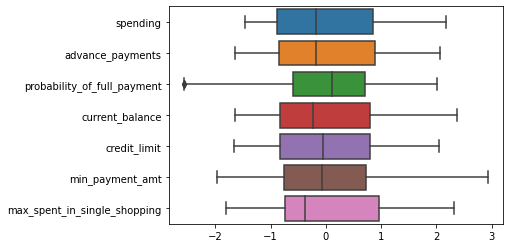

In [519]:
sns.boxplot(data=df_std,orient='h'); # Checking for outliers

Negligible outliers

## 1.3 Apply hierarchical clustering to scaled data. Identify the number of optimum clusters using Dendrogram and briefly describe them

In [63]:
#Hierarchical Clustering

In [520]:
# importing important sklearn libraries

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import silhouette_score

Get the count of unique values for data

In [521]:
df_std.nunique()

spending                        193
advance_payments                170
probability_of_full_payment     184
current_balance                 188
credit_limit                    184
min_payment_amt                 206
max_spent_in_single_shopping    148
dtype: int64

## Creating a dendrogram

We have imported dendrogram and linkage module at the start already.

## Choosing a clustering method

The next for loop is to make a silhouette score list in order to find an appropriate linkage method out of 'ward, 'average',  and 'complete' for hierarchical clustering

In [522]:
siliuette_list_hierarchical = []

for cluster in range(2,20,2):
    for linkage_method in ['ward', 'average', 'complete']:
        agglomerative = AgglomerativeClustering(linkage=linkage_method, affinity='euclidean',n_clusters=cluster).fit_predict(df_std)
        sil_score = metrics.silhouette_score(df_std, agglomerative, metric='euclidean')
        siliuette_list_hierarchical.append((cluster, sil_score, linkage_method, len(set(agglomerative)) ) )
        
df_hierarchical = pd.DataFrame(siliuette_list_hierarchical, columns=['cluster', 'sil_score','linkage_method', 'number_of_clusters'])
# Making a dataframe with these variables

In [523]:
df_hierarchical.sort_values('sil_score', ascending=False)

cluster  sil_score linkage_method  number_of_clusters
0         2   0.461158           ward                   2
1         2   0.441189        average                   2
2         2   0.397924       complete                   2
4         4   0.352612        average                   4
3         4   0.301176           ward                   4
7         6   0.293249        average                   6
10        8   0.282421        average                   8
13       10   0.253262        average                  10
14       10   0.247572       complete                  10
11        8   0.244273       complete                   8
9         8   0.233347           ward                   8
18       14   0.232082           ward                  14
15       12   0.229234           ward                  12
19       14   0.226325        average                  14
17       12   0.223036       complete                  12
12       10   0.222681           ward                  10
24       18   0.220991           ward                  18
8         6   0.215490       complete                   6
21       16   0.215246           ward                  16
6         6   0.215121           ward                   6
5         4   0.207519       complete                   4
22       16   0.205779        average                  16
25       18   0.204940        average                  18
16       12   0.197908        average                  12
26       18   0.196368       complete                  18
20       14   0.192355       complete                  14
23       16   0.191458       complete                  16

We choose the ward method on the basis of the highest silhouette score of 0.461158. Typically, mean silhouette over 0.6 is considered a "good" clustering solution but, for now, this 0.46 is our best option.

In [524]:
wardlink = linkage(df_std, method = 'ward')

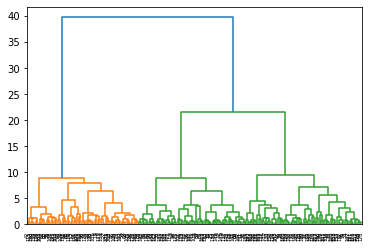

In [525]:
dend = dendrogram(wardlink)

In [526]:
df1.columns

Index(['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping'],
      dtype='object')

In [527]:
X_numerics = df1[['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping']]

In [528]:
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

dist = distance_matrix(X_numerics, X_numerics)
print(dist)

[[0.         4.84379711 1.26000488 ... 7.0105177  4.63461196 4.8895951 ]
 [4.84379711 0.         3.59516985 ... 2.67724004 1.17640255 1.30574679]
 [1.26000488 3.59516985 0.         ... 5.858194   3.4773039  3.74469185]
 ...
 [7.0105177  2.67724004 5.858194   ... 0.         2.39361362 2.28220521]
 [4.63461196 1.17640255 3.4773039  ... 2.39361362 0.         0.87365342]
 [4.8895951  1.30574679 3.74469185 ... 2.28220521 0.87365342 0.        ]]


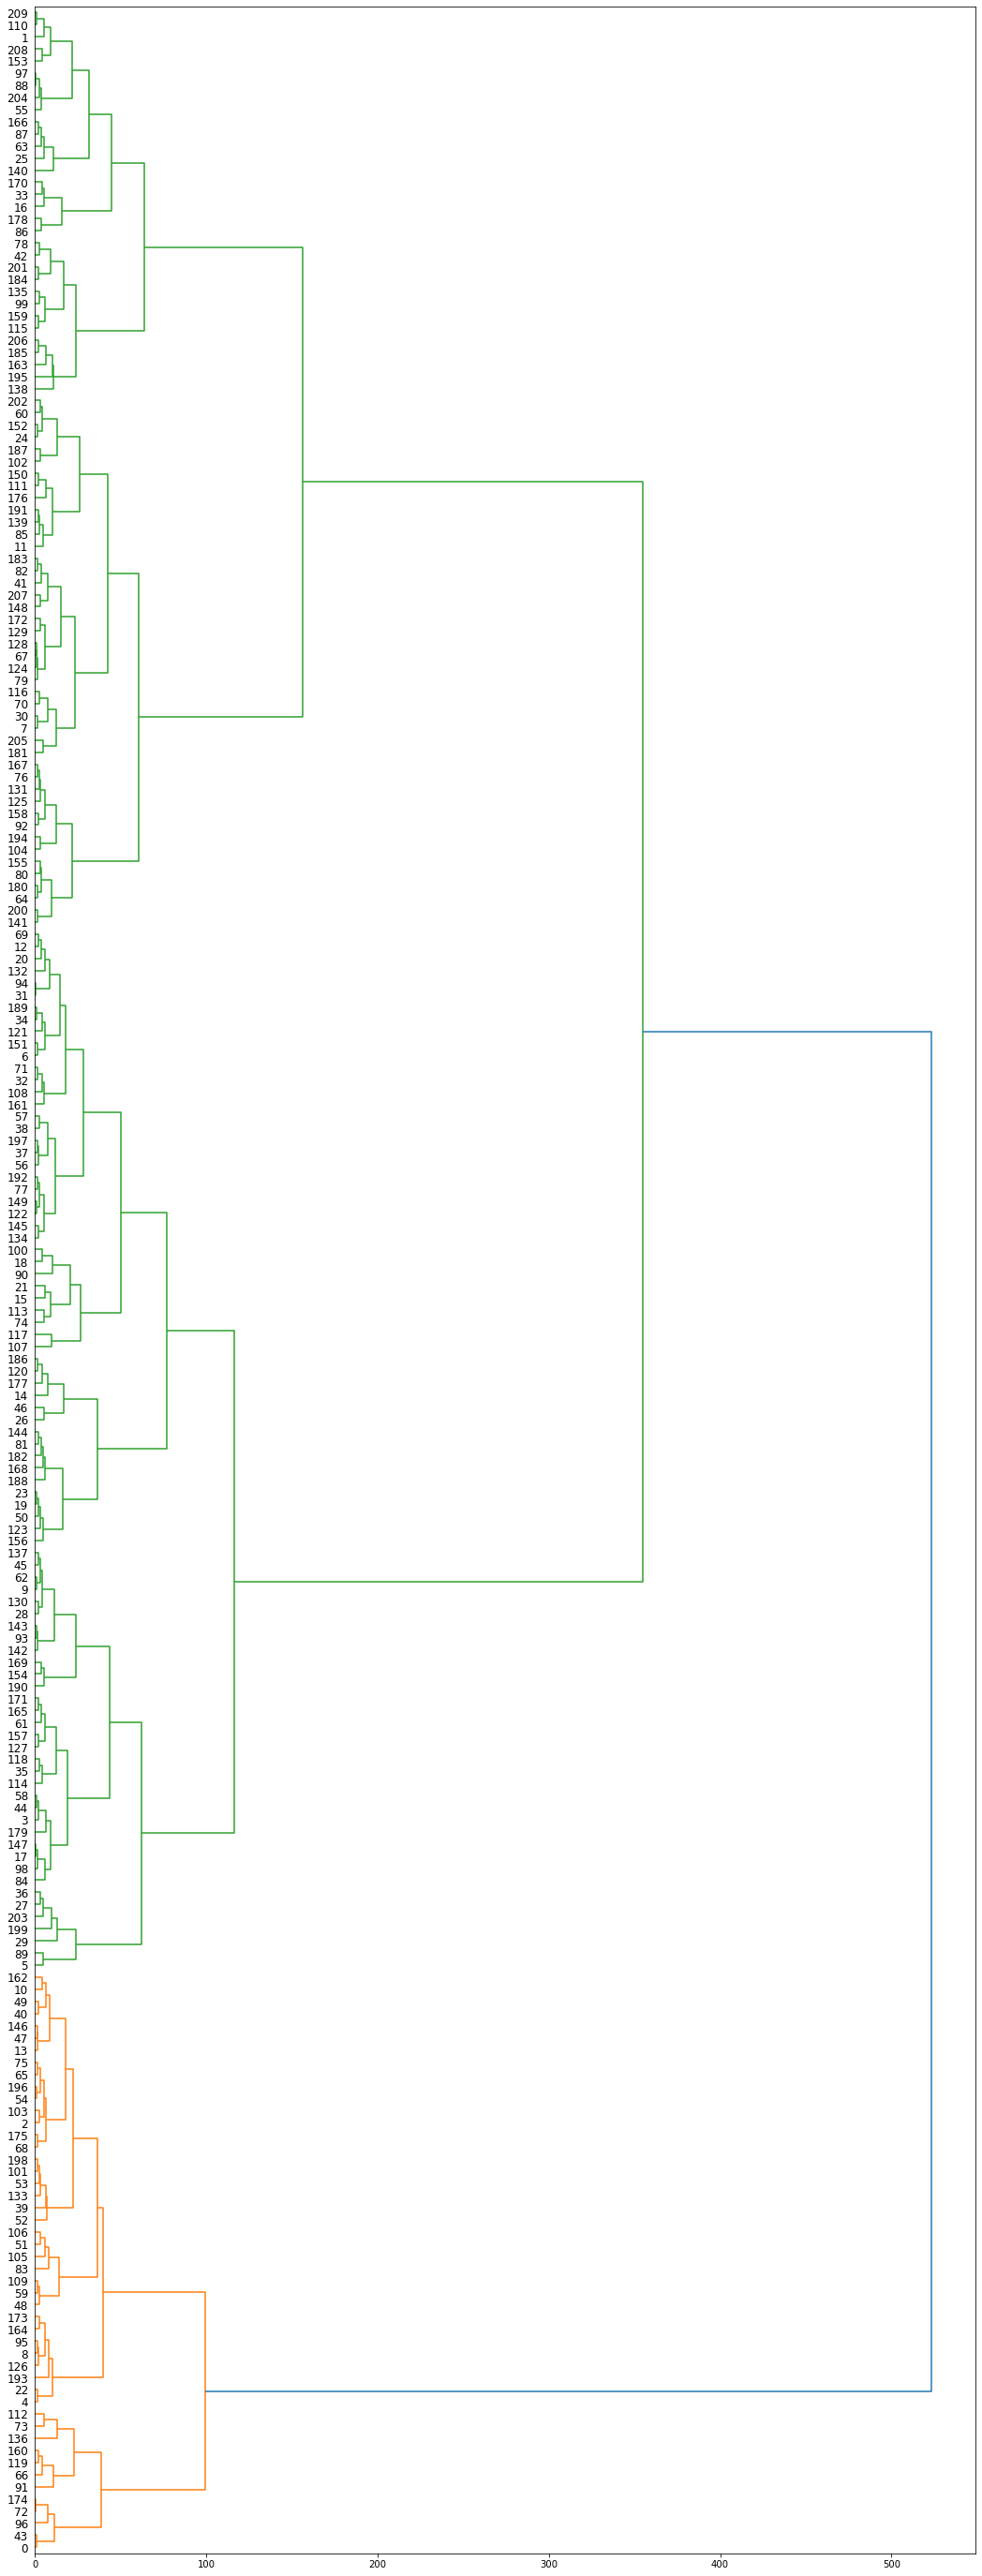

In [529]:
Z = hierarchy.linkage(dist, 'ward')
plt.figure(figsize=(18, 50))
dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size=12, orientation='right')

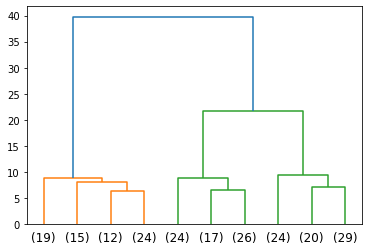

In [530]:
dendro = dendrogram(wardlink,
                 truncate_mode='lastp',
                 p = 10,
                 )

Where to cut this dendrogram? There is no one answer to this. The dendrogram suggests an optimal number (2) based on the colors that it assigns to clusters. At the same time, based on the distance criteria, we can form a different impression on what's optimal. Looking at different metrics and using the knowledge of the data and the clusters, we must make sure that the clusters are heterogeneous or diverse. That way we can optimize the same. If we lower the distance bar, it will cut three lines instead for two, and three might then be the optimal number of clusters. We'll do one thing: make both 2-cluster and 3-cluster models and then choose one that is less costlier to the business and more heterogeneous.

## Importing fcluster module to create clusters

In [531]:
from scipy.cluster.hierarchy import fcluster

In [532]:
# Set criterion as distance,then create 2 clusters, and then store the result in another object called 'clusters'.

clusters = fcluster(wardlink, 25, criterion='distance')
clusters

array([1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1,
       2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2], dtype=int32)

## Appending clusters to original database

In [533]:
df1['clusters'] = clusters

In [534]:
df1.head()

spending  advance_payments  probability_of_full_payment  current_balance  \
0     19.94             16.92                     0.875200            6.675   
1     15.99             14.89                     0.906400            5.363   
2     18.95             16.42                     0.882900            6.248   
3     10.83             12.96                     0.810588            5.278   
4     17.99             15.86                     0.899200            5.890   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  clusters  
0         3.763            3.252                         6.550         1  
1         3.582            3.336                         5.144         2  
2         3.755            3.368                         6.148         1  
3         2.641            5.182                         5.185         2  
4         3.694            2.068                         5.837         1

## Cluster frequency

In [535]:
df1.clusters.value_counts().sort_index()

1     70
2    140
Name: clusters, dtype: int64

Cluster 1 has 70 records, while cluster 2 has 140 out of 210.

In [536]:
df1.to_csv('hicu.csv')

## Cluster Profiles

In [537]:
aggdata=df1.iloc[:,0:8].groupby('clusters').mean()
aggdata['Freq']=df1.clusters.value_counts().sort_index()
aggdata

spending  advance_payments  probability_of_full_payment  \
clusters                                                             
1         18.371429         16.145429                     0.884400   
2         13.085571         13.766214                     0.864338   

          current_balance  credit_limit  min_payment_amt  \
clusters                                                   
1                6.158171      3.684629         3.639157   
2                5.363714      3.045593         3.726353   

          max_spent_in_single_shopping  Freq  
clusters                                      
1                             6.017371    70  
2                             5.103421   140

Cluster 1: High spenders with more advance payment and higher average maximum spend in single shopping

Cluster 2: Low spenders with less advance payment and lower average maximum spend in single shopping

## Using Agglomerative Clustering

Specific sklearn library imported already

In [538]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
Cluster_agglo=cluster.fit_predict(df1.iloc[:,0:8])
print(Cluster_agglo)

[1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1
 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0
 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0]


In [539]:
df1["Agglo_CLusters"]=Cluster_agglo

In [540]:
df1.columns

Index(['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping', 'clusters', 'Agglo_CLusters'],
      dtype='object')

In [541]:
agglo_data= df1.iloc[:,0:9].groupby('Agglo_CLusters').mean()
agglo_data['Freq']=df1.Agglo_CLusters.value_counts().sort_index()
agglo_data

spending  advance_payments  probability_of_full_payment  \
Agglo_CLusters                                                             
0               13.232517         13.830612                     0.865492   
1               18.615873         16.259524                     0.883937   

                current_balance  credit_limit  min_payment_amt  \
Agglo_CLusters                                                   
0                      5.385932      3.065946         3.713520   
1                      6.194603      3.708143         3.659413   

                max_spent_in_single_shopping  clusters  Freq  
Agglo_CLusters                                                
0                                   5.128265  1.952381   147  
1                                   6.060952  1.000000    63

## Recommendations

In [542]:
df1[df1['clusters']==1].describe()

spending  advance_payments  probability_of_full_payment  \
count  70.000000         70.000000                    70.000000   
mean   18.371429         16.145429                     0.884400   
std     1.381233          0.599277                     0.014767   
min    15.380000         14.860000                     0.845200   
25%    17.330000         15.737500                     0.874700   
50%    18.720000         16.210000                     0.883950   
75%    19.137500         16.557500                     0.898225   
max    21.180000         17.250000                     0.910800   

       current_balance  credit_limit  min_payment_amt  \
count        70.000000     70.000000        70.000000   
mean          6.158171      3.684629         3.639157   
std           0.245926      0.174909         1.208271   
min           5.709000      3.268000         1.472000   
25%           5.979250      3.554250         2.845500   
50%           6.148500      3.693500         3.629000   
75%           6.312000      3.804750         4.459250   
max           6.675000      4.033000         6.682000   

       max_spent_in_single_shopping  clusters  Agglo_CLusters  
count                     70.000000      70.0       70.000000  
mean                       6.017371       1.0        0.900000  
std                        0.251132       0.0        0.302166  
min                        5.443000       1.0        0.000000  
25%                        5.877000       1.0        1.000000  
50%                        5.981500       1.0        1.000000  
75%                        6.187750       1.0        1.000000  
max                        6.550000       1.0        1.000000

In [543]:
df1[df1['clusters']==2].describe()

spending  advance_payments  probability_of_full_payment  \
count  140.000000        140.000000                   140.000000   
mean    13.085571         13.766214                     0.864338   
std      1.550003          0.696916                     0.024315   
min     10.590000         12.410000                     0.810588   
25%     11.817500         13.207500                     0.848075   
50%     12.770000         13.665000                     0.865800   
75%     14.347500         14.305000                     0.882075   
max     16.630000         15.460000                     0.918300   

       current_balance  credit_limit  min_payment_amt  \
count       140.000000    140.000000       140.000000   
mean          5.363714      3.045593         3.726353   
std           0.230740      0.249454         1.622319   
min           4.899000      2.630000         0.765100   
25%           5.179000      2.835250         2.461750   
50%           5.351000      3.037000         3.597500   
75%           5.521750      3.234500         4.879250   
max           6.053000      3.582000         8.079625   

       max_spent_in_single_shopping  clusters  Agglo_CLusters  
count                    140.000000     140.0           140.0  
mean                       5.103421       2.0             0.0  
std                        0.226834       0.0             0.0  
min                        4.519000       2.0             0.0  
25%                        5.000000       2.0             0.0  
50%                        5.091500       2.0             0.0  
75%                        5.222500       2.0             0.0  
max                        5.879000       2.0             0.0

## Outcomes

1. Like said before, customers from cluster 1 are better at advance_payments than those in cluster 2.

2. Examination of the mean and standard deviation shows that the customers in cluster 1 have a higher spending habit than those in cluster 2.

3. Cluster 1 spends more in single shopping, yet both clusters have only a marginal difference in credit_limit.

4. Their probabilities of making full payment are almost the same.

## Suggestions

1. Since customers in cluster 2 lag in advance payment, the bank can introduce schemes such as doubling the reward points of whoever pays in advance.

2. To increase the minimum payment amount, the bank can introduce some cashback offers of up to a certain amount's worth of minimum purchase.

3. Since the customers in cluster 1 have a better record, the bank can consider them its premium clients and think of introducing cashback offers for them to encourage more on spending.

4. It'll be fair and good to increase the credit_limit of primium clients to separate them from normal customers. Also because there is a strong correlation between spending and credit limit. We can increase the credit limit for both category of customer segments while giving the higher spenders a lot more freedom.

## Saving the Cluster Profiles in a csv file

In [544]:
aggdata.to_csv('bank_hc.csv')

## Checking out the 3-cluster model

In [545]:
df_std.head()

spending  advance_payments  probability_of_full_payment  current_balance  \
0  1.754355          1.811968                     0.177628         2.367533   
1  0.393582          0.253840                     1.505071        -0.600744   
2  1.413300          1.428192                     0.505234         1.401485   
3 -1.384034         -1.227533                    -2.571391        -0.793049   
4  1.082581          0.998364                     1.198738         0.591544   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  
0      1.338579        -0.298625                      2.328998  
1      0.858236        -0.242292                     -0.538582  
2      1.317348        -0.220832                      1.509107  
3     -1.639017         0.995699                     -0.454961  
4      1.155464        -1.092656                      0.874813

In [546]:
wardlink = linkage(df_std, method = 'ward')

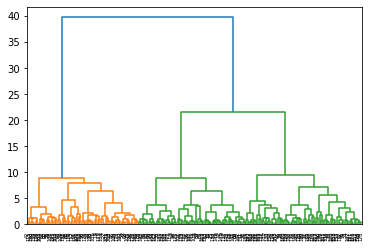

In [547]:
dend = dendrogram(wardlink)

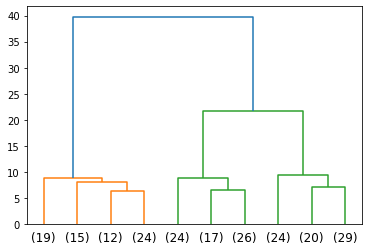

In [548]:
dendro = dendrogram(wardlink,
                 truncate_mode='lastp',
                 p = 10,
                 )

In [549]:
clusters = fcluster(wardlink, 20, criterion='distance')
clusters

array([1, 3, 1, 2, 1, 2, 2, 3, 1, 2, 1, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2,
       1, 2, 3, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 3, 3, 1,
       1, 3, 1, 2, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3, 3, 3, 3, 1, 2, 3, 3, 1,
       1, 2, 3, 1, 3, 2, 2, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 1, 1, 2, 2, 1,
       3, 3, 1, 2, 2, 1, 3, 3, 2, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 3, 2, 3,
       3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 3,
       3, 3, 3, 2, 3, 1, 1, 2, 1, 1, 1, 2, 1, 3, 3, 3, 3, 2, 3, 1, 1, 1,
       3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 2, 1, 3, 1, 1, 2,
       1, 2, 3, 1, 3, 2, 1, 3, 1, 3, 1, 3], dtype=int32)

In [550]:
df1['clusters'] = clusters

In [551]:
df1.head()

spending  advance_payments  probability_of_full_payment  current_balance  \
0     19.94             16.92                     0.875200            6.675   
1     15.99             14.89                     0.906400            5.363   
2     18.95             16.42                     0.882900            6.248   
3     10.83             12.96                     0.810588            5.278   
4     17.99             15.86                     0.899200            5.890   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  clusters  \
0         3.763            3.252                         6.550         1   
1         3.582            3.336                         5.144         3   
2         3.755            3.368                         6.148         1   
3         2.641            5.182                         5.185         2   
4         3.694            2.068                         5.837         1   

   Agglo_CLusters  
0               1  
1               0  
2               1  
3               0  
4               1

In [552]:
df1.clusters.value_counts().sort_index()

1    70
2    67
3    73
Name: clusters, dtype: int64

Cluster 1 has 70 records like before, but we have two new clusters, 2 and 3, with 67 and 73 records, respectively, out of 210.

In [553]:
aggdata3=df1.iloc[:,0:8].groupby('clusters').mean()
aggdata3['Freq']=df1.clusters.value_counts().sort_index()
aggdata3

spending  advance_payments  probability_of_full_payment  \
clusters                                                             
1         18.371429         16.145429                     0.884400   
2         11.872388         13.257015                     0.848155   
3         14.199041         14.233562                     0.879190   

          current_balance  credit_limit  min_payment_amt  \
clusters                                                   
1                6.158171      3.684629         3.639157   
2                5.238940      2.848537         4.940302   
3                5.478233      3.226452         2.612181   

          max_spent_in_single_shopping  Freq  
clusters                                      
1                             6.017371    70  
2                             5.122209    67  
3                             5.086178    73

Cluster 1: High spenders with high advance payments

Cluster 2: Low spenders with high minimum payment amount and low credit limit

Cluster 3: Medium spenders with advance payment level 14 and least minimum payment amount of all three segments

## Using Agglomerative Clustering

In [554]:
cluster3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
Cluster_agglo3=cluster3.fit_predict(df1.iloc[:,0:8])
print(Cluster_agglo3)

[0 1 0 2 0 2 2 1 0 2 0 1 2 0 1 2 1 2 1 2 2 2 0 2 1 0 1 2 2 2 1 2 2 1 2 2 2
 2 2 0 0 1 0 0 2 2 1 0 0 0 2 0 0 0 0 0 2 2 2 0 1 2 2 1 1 0 0 1 0 2 1 2 0 0
 2 0 1 2 0 1 1 1 1 0 2 1 1 0 0 2 2 0 1 2 2 0 0 0 2 0 2 0 1 0 1 0 0 2 2 0 1
 1 0 2 2 0 1 2 2 0 1 2 2 2 1 1 0 2 1 1 2 1 1 0 2 0 0 2 0 1 1 1 2 2 1 2 0 2
 1 2 1 2 1 1 1 1 1 2 1 0 0 2 0 0 0 2 0 1 1 1 1 2 1 0 0 0 1 1 0 2 1 1 1 1 0
 0 1 1 1 2 1 1 2 0 1 0 0 2 0 2 1 0 1 2 0 1 0 1 0 1]


In [555]:
df1["Agglo_CLusters3"]=Cluster_agglo3

In [556]:
df1.columns

Index(['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping', 'clusters', 'Agglo_CLusters',
       'Agglo_CLusters3'],
      dtype='object')

In [557]:
agglo_data3= df1.iloc[:,0:10].groupby('Agglo_CLusters3').mean()
agglo_data3['Freq']=df1.Agglo_CLusters3.value_counts().sort_index()
agglo_data3

spending  advance_payments  probability_of_full_payment  \
Agglo_CLusters3                                                             
0                18.371429         16.145429                     0.884400   
1                14.200845         14.240141                     0.878425   
2                11.937971         13.278551                     0.849841   

                 current_balance  credit_limit  min_payment_amt  \
Agglo_CLusters3                                                   
0                       6.158171      3.684629         3.639157   
1                       5.484437      3.223239         2.517890   
2                       5.239493      2.862797         4.969844   

                 max_spent_in_single_shopping  clusters  Agglo_CLusters  Freq  
Agglo_CLusters3                                                                
0                                    6.017371  1.000000             0.9    70  
1                                    5.091676  3.000000             0.0    71  
2                                    5.115507  2.028986             0.0    69

In [558]:
agglo_data3= df1.iloc[:,0:10].groupby('Agglo_CLusters3').sum()
agglo_data3['Freq']=df1.Agglo_CLusters3.value_counts().sort_index()
agglo_data3

spending  advance_payments  probability_of_full_payment  \
Agglo_CLusters3                                                            
0                 1286.00           1130.18                    61.908000   
1                 1008.26           1011.05                    62.368200   
2                  823.72            916.22                    58.639063   

                 current_balance  credit_limit  min_payment_amt  \
Agglo_CLusters3                                                   
0                        431.072       257.924        254.74100   
1                        389.395       228.850        178.77020   
2                        361.525       197.533        342.91925   

                 max_spent_in_single_shopping  clusters  Agglo_CLusters  Freq  
Agglo_CLusters3                                                                
0                                     421.216        70              63    70  
1                                     361.509       213               0    71  
2                                     352.970       140               0    69

In [559]:
agglo_data3= df1.iloc[:,0:10].groupby('Agglo_CLusters3').max()
agglo_data3['Freq']=df1.Agglo_CLusters3.value_counts().sort_index()
agglo_data3

spending  advance_payments  probability_of_full_payment  \
Agglo_CLusters3                                                            
0                   21.18             17.25                       0.9108   
1                   16.63             15.46                       0.9153   
2                   14.28             14.17                       0.9183   

                 current_balance  credit_limit  min_payment_amt  \
Agglo_CLusters3                                                   
0                          6.675         4.033         6.682000   
1                          6.053         3.582         5.593000   
2                          5.541         3.383         8.079625   

                 max_spent_in_single_shopping  clusters  Agglo_CLusters  Freq  
Agglo_CLusters3                                                                
0                                       6.550         1               1    70  
1                                       5.879         3               0    71  
2                                       5.491         3               0    69

In [560]:
agglo_data3= df1.iloc[:,0:10].groupby('Agglo_CLusters3').min()
agglo_data3['Freq']=df1.Agglo_CLusters3.value_counts().sort_index()
agglo_data3

spending  advance_payments  probability_of_full_payment  \
Agglo_CLusters3                                                            
0                   15.38             14.86                     0.845200   
1                   11.23             12.63                     0.833500   
2                   10.59             12.41                     0.810588   

                 current_balance  credit_limit  min_payment_amt  \
Agglo_CLusters3                                                   
0                          5.709         3.268           1.4720   
1                          4.902         2.719           0.7651   
2                          4.899         2.630           3.0820   

                 max_spent_in_single_shopping  clusters  Agglo_CLusters  Freq  
Agglo_CLusters3                                                                
0                                       5.443         1               0    70  
1                                       4.519         3               0    71  
2                                       4.781         2               0    69

In [561]:
aggdata3.to_csv('bank3_hc.csv')

## Recommendations

Beyond what has been proposed for the two categories before, here's something more we propose:-

1. Colour scheme: Using a simple colour scheme, the bank can introduce the gold, silver, and platinum cards for the three classes of customers, with a varying degree of benefits and special privileges such as extra points. Add higher limits, fees, reward points, and cache to higher cards.

2. Loans: These cards can come with pre-approved loans (for housing, car, education, and retail), say silver for Rs 25 lakh,  gold for Rs 25 lakh to Rs 50 lakh, and platinum for Rs 50 lakh to Rs 1 crore.

3. Rating: The bank can start card-based credit rating to encourage more full payments.

4. Show time: Run a scheme that allows card holders access to coveted show tickets before they are available to the general public. That'll encourage more spending across categories.

5. Link it to cash: The platinum card, which, in addition to quadrupling the gold card fees, could offer cash availability anywhere around the world without the need for a cheque, besides hotel upgrades when available and other travel and concierge services.

6. Top class: Create a high-quality magazine aimed solely at the top segment (which will also make big money on the advertising on account of being desired by high-end vendors as one of the very few magazines targeted fully to their target audience. The vendors will minimize wasted advertising.

7. Let's play: Offers exclusive performances and evenings with different artists, authors, actors etc. Top spenders should get IPL, Euro Cup, World Cup box tickets for sense of exclusivity and greater following.

8. Boss card: Introduce high-end credit card differentiation. Beyond silver, gold, or platinum, call it "the Boss card" or something, so exclusive you shouldn't be able to apply for it. It's a "by invitation only" product, and the invitations are extended only to the most credit-worthy customers, who spend at least a certain high amount of money using their card annually. Put a price on it and the card should be hand delivered in a designer box. Exclusive customers seek exclusive items and experiences.

9. Reward: Reward the customers for the length and size of business. This will encourage them to stay with the bank, which will save it the cost of acquiring new customers. Instead of validity date, the cards could say: "Member since".

10. Use digital age: Allow customers to transfer money via smartphone using their card number at any time using. This will encourage more middle spenders towards cashless transaction.

11. A card they can bank on: To attract low spenders towards using their credit card more often or exploring more of its applications, add traditional banking features such as account opening, money transfer, bill payment, and retail transactions, since this class has to queue up for most of these services, otherwise. The bank can also link it with subsidies.

12. Hacker-proof: For high spenders at least, replace magnectic strip on the card with biometric authentication to make their accounts and transactions safer, as they will use biometric scans in place of PIN or password. Remember, their accounts are bank's cash cow.

## Suggested model out of the two

## Go with 3 clusters

Since cluster analysis is essentially an exploratory approach, the interpretation of the resulting hierarchical structure is context-dependent and often several solutions are equally good from a theoretical point of view.

Even though cheaper, a generic credit card scheme tailored to the average will have the lowest response rate. A scheme that is tailored to each individual will have the highest cost. Three schemes tailored to three segments will be somewhere in between. This is the revenue side.

The silhouette score is best for 2 clusters but it's still far below 0.6. The score is only 0.46 or so, so,  one the clusters are not all that well separated, and two, the chances of calling it right are less than 50%.

To maximize profit, the bank would want to keep segmenting until the marginal revenue from segmenting equals the marginal cost of segmenting. In this case study, our suggestion to the bank is to use three segments to maximize profit. The cost of losing a customer segment can be huge. 

## 1.4 Apply K-Means clustering on scaled data and determine optimum clusters. Apply elbow curve and silhouette score.

In [562]:
# KMeans

In order to find an appropriate number of clusters, the elbow method will be used. 

In this method for this case, the inertia for a number of clusters between 2 and 10 will be calculated. 

The rule is to choose the number of clusters where you see a kink or "an elbow" in the graph.

## Calculating Within Cluster Sum of Squares or WSS for 10 values of K

In [563]:
wss =[]

In [564]:
for i in range(1,11):
    KM = KMeans(n_clusters=i)
    KM.fit(df_std)
    wss.append(KM.inertia_)

In [565]:
wss

[1469.999999999999,
 659.14740095485,
 430.298481751223,
 370.6909292210199,
 327.8379162768708,
 294.70740950686735,
 262.5742242335426,
 240.20718392679387,
 222.41512322267613,
 205.2353741836641]

In [566]:
a=[1,2,3,4,5,6,7,8,9,10]

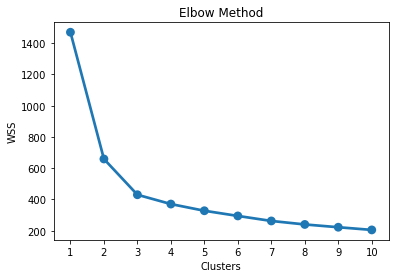

In [567]:
sns.pointplot(a, wss);
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WSS')
plt.show()

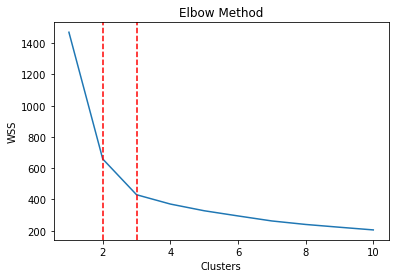

In [568]:
plt.plot(range(1,11), wss);
plt.axvline(x=2,color='red', linestyle='--')
plt.axvline(x=3,color='red', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WSS')
plt.show()

In [569]:
# Kmeans with Different Number of Clusters from 2 to 10

In [570]:
kmeans_values=[]

for cluster in range(2,11):
    kmeans = KMeans(n_clusters=cluster, random_state=40).fit_predict(df_std)
    sil_score = metrics.silhouette_score(df_std,kmeans, metric='euclidean')
    print("Silhouette score for {} cluster k-means: {:.3f}".format(cluster,
                                                               metrics.silhouette_score(df_std, kmeans, metric='euclidean')))
    kmeans_values.append((cluster,sil_score))

Silhouette score for 2 cluster k-means: 0.466
Silhouette score for 3 cluster k-means: 0.401
Silhouette score for 4 cluster k-means: 0.335
Silhouette score for 5 cluster k-means: 0.281
Silhouette score for 6 cluster k-means: 0.277
Silhouette score for 7 cluster k-means: 0.276
Silhouette score for 8 cluster k-means: 0.265
Silhouette score for 9 cluster k-means: 0.272
Silhouette score for 10 cluster k-means: 0.260


We have a double elbow, at 2 and 3 clusters, marked with vertical red lines. The other clusters have very little intertia.

In [178]:
# Silhouette score method indicates the best options would be 2 or 3 clusters. Let's compare both.

# Sizing up the clusters

In [571]:
KM_2_clusters = KMeans(n_clusters=2, init='k-means++').fit(df_std) # initialise and fit K-Means model

KM2_clustered = df_std.copy()
KM2_clustered.loc[:,'Cluster'] = KM_2_clusters.labels_ # append labels to points

In [572]:
KM2_clust_sizes = KM2_clustered.groupby('Cluster').size().to_frame()
KM2_clust_sizes.columns = ["KM2_size"]
KM2_clust_sizes

KM2_size
Cluster          
0              77
1             133

In [573]:
KM_3_clusters = KMeans(n_clusters=3, init='k-means++').fit(df_std) # initialise and fit K-Means model

KM3_clustered = df_std.copy()
KM3_clustered.loc[:,'Cluster'] = KM_3_clusters.labels_ # append labels to points

In [574]:
KM3_clust_sizes = KM3_clustered.groupby('Cluster').size().to_frame()
KM3_clust_sizes.columns = ["KM3_size"]
KM3_clust_sizes

KM3_size
Cluster          
0              71
1              72
2              67

# Looking into the cluster sizes across both algorithms

In [575]:
clusters = pd.concat([KM2_clust_sizes, KM3_clust_sizes],axis=1, sort=False)
clusters

KM2_size  KM3_size
Cluster                    
0            77.0        71
1           133.0        72
2             NaN        67

Silhouette score is better for 2 clusters than for 3 clusters.
But we should also look at the elbow method. 
To determine the optimal number of clusters, we have to select the value of k at the “elbow”, i.e. the point after which the distortion/inertia starts decreasing in a linear fashion for the given data.
We conclude that the optimal number of clusters for the data is 3.
It also seems from the size comparison of the algorithms that KMeans model with 3 clusters has more evenly balanced observations.
We'll go with 3 clusters.

## KMeans with K=3

In [576]:
# k_means = KMeans(n_clusters = 3)
# k_means.fit(df_std)
# labels = k_means.labels_
# labels

In [577]:
kmeans3 = KMeans(n_clusters=3, random_state=1).fit(df_std)
labels = kmeans3.labels_
labels

array([0, 2, 0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1,
       0, 1, 2, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0,
       1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 1, 2, 2, 0,
       0, 2, 0, 1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2,
       0, 1, 2, 0, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 1, 0,
       2, 2, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1, 2,
       2, 0, 1, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 0, 0, 1, 0, 0, 0, 1, 2, 2, 2, 1, 2, 1, 2, 0, 0, 0,
       2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 1, 2, 1, 0, 2, 0, 0, 1,
       0, 1, 2, 0, 2, 1, 0, 2, 0, 2, 2, 2])

# Appending Clusters to the original dataset

In [578]:
df1['KM3_cluster'] = labels

In [579]:
df1.head()

spending  advance_payments  probability_of_full_payment  current_balance  \
0     19.94             16.92                     0.875200            6.675   
1     15.99             14.89                     0.906400            5.363   
2     18.95             16.42                     0.882900            6.248   
3     10.83             12.96                     0.810588            5.278   
4     17.99             15.86                     0.899200            5.890   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  clusters  \
0         3.763            3.252                         6.550         1   
1         3.582            3.336                         5.144         3   
2         3.755            3.368                         6.148         1   
3         2.641            5.182                         5.185         2   
4         3.694            2.068                         5.837         1   

   Agglo_CLusters  Agglo_CLusters3  KM3_cluster  
0               1                0            0  
1               0                1            2  
2               1                0            0  
3               0                2            1  
4               1                0            0

# Saving the Cluster Profiles in a csv file

In [580]:
df1.to_csv('bankcs_km.csv')

# Cluster Profiling

In [581]:
df1.KM3_cluster.value_counts().sort_index()

0    67
1    72
2    71
Name: KM3_cluster, dtype: int64

In [582]:
clust_profile=df1
clust_profile=clust_profile.groupby('KM3_cluster').mean()
clust_profile['freq']=df1.KM3_cluster.value_counts().sort_index()
clust_profile

spending  advance_payments  probability_of_full_payment  \
KM3_cluster                                                             
0            18.495373         16.203433                     0.884210   
1            11.856944         13.247778                     0.848330   
2            14.437887         14.337746                     0.881597   

             current_balance  credit_limit  min_payment_amt  \
KM3_cluster                                                   
0                   6.175687      3.697537         3.632373   
1                   5.231750      2.849542         4.733892   
2                   5.514577      3.259225         2.707341   

             max_spent_in_single_shopping  clusters  Agglo_CLusters  \
KM3_cluster                                                           
0                                6.041701  1.029851        0.940299   
1                                5.101722  2.083333        0.000000   
2                                5.120803  2.873239        0.000000   

             Agglo_CLusters3  freq  
KM3_cluster                         
0                   0.014925    67  
1                   1.916667    72  
2                   0.985915    71

In [ ]:
# Three customer segments similar to the ones detected by hierarchical clustering model. We'll describe those, later.

# Model evaluation

Showing silhouette score once again

In [583]:
from sklearn.metrics import silhouette_samples
silhouette_score(df_std,labels)

0.4008059221522216

# Computing silhouette width

In [584]:
sil_width = silhouette_samples(df_std,labels)
sil_width

array([0.5732776 , 0.36556355, 0.63709249, 0.515595  , 0.36097201,
       0.22152508, 0.47529542, 0.36025848, 0.51938329, 0.53443903,
       0.46599399, 0.12839864, 0.39177784, 0.52379458, 0.11202082,
       0.22512083, 0.33760956, 0.5018087 , 0.03635503, 0.23801566,
       0.36177434, 0.3693663 , 0.43153403, 0.26364196, 0.47484293,
       0.06663956, 0.27151643, 0.50414367, 0.55487254, 0.43479958,
       0.37528473, 0.43006502, 0.39151526, 0.3943622 , 0.5362567 ,
       0.55717776, 0.50878421, 0.42617776, 0.50641159, 0.62170114,
       0.55929539, 0.48579454, 0.39864428, 0.61044051, 0.51398993,
       0.37791063, 0.30664315, 0.58154614, 0.48759463, 0.53302467,
       0.31693425, 0.49463828, 0.58531649, 0.59861082, 0.61892471,
       0.23370264, 0.44475373, 0.54060572, 0.57808265, 0.57623567,
       0.55297302, 0.51585343, 0.55579575, 0.27793624, 0.49524145,
       0.56405298, 0.57784591, 0.52274801, 0.6313322 , 0.08521853,
       0.44260057, 0.3237709 , 0.54096805, 0.5820664 , 0.29582

# Appending sihouette width to dataset

In [585]:
df1["sil_width"] = sil_width
df1.head()

spending  advance_payments  probability_of_full_payment  current_balance  \
0     19.94             16.92                     0.875200            6.675   
1     15.99             14.89                     0.906400            5.363   
2     18.95             16.42                     0.882900            6.248   
3     10.83             12.96                     0.810588            5.278   
4     17.99             15.86                     0.899200            5.890   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  clusters  \
0         3.763            3.252                         6.550         1   
1         3.582            3.336                         5.144         3   
2         3.755            3.368                         6.148         1   
3         2.641            5.182                         5.185         2   
4         3.694            2.068                         5.837         1   

   Agglo_CLusters  Agglo_CLusters3  KM3_cluster  sil_width  
0               1                0            0   0.573278  
1               0                1            2   0.365564  
2               1                0            0   0.637092  
3               0                2            1   0.515595  
4               1                0            0   0.360972

# Minimum silhouette width

In [586]:
silhouette_samples(df_std,labels).min()

0.0027685411286160638

# Checking for any negative silhouette width

In [587]:
df1[df1['sil_width'] < 0]

Empty DataFrame
Columns: [spending, advance_payments, probability_of_full_payment, current_balance, credit_limit, min_payment_amt, max_spent_in_single_shopping, clusters, Agglo_CLusters, Agglo_CLusters3, KM3_cluster, sil_width]
Index: []

The minimum silhouette width is on the positive side of zero but not closer to 1, so there are clusters, even though not well separated. There is no record with negative silhouette score, which means that the classification was proper. The model is verified.

# High spenders cluster description

In [588]:
df1[df1['KM3_cluster'] == 0].describe()

spending  advance_payments  probability_of_full_payment  \
count  67.000000         67.000000                    67.000000   
mean   18.495373         16.203433                     0.884210   
std     1.277122          0.546439                     0.014917   
min    15.560000         14.890000                     0.845200   
25%    17.590000         15.855000                     0.874650   
50%    18.750000         16.230000                     0.882900   
75%    19.145000         16.580000                     0.898050   
max    21.180000         17.250000                     0.910800   

       current_balance  credit_limit  min_payment_amt  \
count        67.000000     67.000000        67.000000   
mean          6.175687      3.697537         3.632373   
std           0.237807      0.166014         1.211052   
min           5.718000      3.387000         1.472000   
25%           6.011500      3.564500         2.848000   
50%           6.153000      3.719000         3.619000   
75%           6.328000      3.808000         4.421000   
max           6.675000      4.033000         6.682000   

       max_spent_in_single_shopping   clusters  Agglo_CLusters  \
count                     67.000000  67.000000       67.000000   
mean                       6.041701   1.029851        0.940299   
std                        0.229566   0.244339        0.238721   
min                        5.484000   1.000000        0.000000   
25%                        5.879000   1.000000        1.000000   
50%                        6.009000   1.000000        1.000000   
75%                        6.192500   1.000000        1.000000   
max                        6.550000   3.000000        1.000000   

       Agglo_CLusters3  KM3_cluster  sil_width  
count        67.000000         67.0  67.000000  
mean          0.014925          0.0   0.468077  
std           0.122169          0.0   0.153426  
min           0.000000          0.0   0.030368  
25%           0.000000          0.0   0.418991  
50%           0.000000          0.0   0.522797  
75%           0.000000          0.0   0.573763  
max           1.000000          0.0   0.638681

# Low spenders cluster description

In [589]:
df1[df1['KM3_cluster'] == 1].describe()

spending  advance_payments  probability_of_full_payment  \
count  72.000000         72.000000                    72.000000   
mean   11.856944         13.247778                     0.848330   
std     0.714801          0.355208                     0.019800   
min    10.590000         12.410000                     0.810588   
25%    11.255000         12.992500                     0.835000   
50%    11.825000         13.250000                     0.848600   
75%    12.395000         13.482500                     0.861475   
max    13.340000         13.950000                     0.888300   

       current_balance  credit_limit  min_payment_amt  \
count        72.000000     72.000000        72.000000   
mean          5.231750      2.849542         4.733892   
std           0.141795      0.138689         1.332248   
min           4.899000      2.630000         1.502000   
25%           5.139250      2.738500         4.032250   
50%           5.225000      2.836500         4.799000   
75%           5.337250      2.967000         5.463750   
max           5.541000      3.232000         8.079625   

       max_spent_in_single_shopping   clusters  Agglo_CLusters  \
count                     72.000000  72.000000            72.0   
mean                       5.101722   2.083333             0.0   
std                        0.184012   0.278325             0.0   
min                        4.519000   2.000000             0.0   
25%                        5.001000   2.000000             0.0   
50%                        5.089000   2.000000             0.0   
75%                        5.223500   2.000000             0.0   
max                        5.491000   3.000000             0.0   

       Agglo_CLusters3  KM3_cluster  sil_width  
count        72.000000         72.0  72.000000  
mean          1.916667          1.0   0.399556  
std           0.278325          0.0   0.159393  
min           1.000000          1.0   0.002769  
25%           2.000000          1.0   0.316372  
50%           2.000000          1.0   0.459725  
75%           2.000000          1.0   0.516781  
max           2.000000          1.0   0.588665

# Medium spenders cluster description

In [590]:
df1[df1['KM3_cluster'] == 2].describe()

spending  advance_payments  probability_of_full_payment  \
count  71.000000         71.000000                    71.000000   
mean   14.437887         14.337746                     0.881597   
std     1.056513          0.525706                     0.015502   
min    12.080000         13.150000                     0.852700   
25%    13.820000         14.030000                     0.871300   
50%    14.430000         14.390000                     0.881900   
75%    15.260000         14.760000                     0.893350   
max    16.440000         15.270000                     0.918300   

       current_balance  credit_limit  min_payment_amt  \
count        71.000000     71.000000        71.000000   
mean          5.514577      3.259225         2.707341   
std           0.225266      0.154766         1.176440   
min           4.984000      2.936000         0.765100   
25%           5.380000      3.155000         1.951000   
50%           5.541000      3.258000         2.640000   
75%           5.689500      3.378000         3.332000   
max           5.920000      3.582000         6.685000   

       max_spent_in_single_shopping   clusters  Agglo_CLusters  \
count                     71.000000  71.000000            71.0   
mean                       5.120803   2.873239             0.0   
std                        0.269558   0.475983             0.0   
min                        4.605000   1.000000             0.0   
25%                        4.958500   3.000000             0.0   
50%                        5.132000   3.000000             0.0   
75%                        5.263500   3.000000             0.0   
max                        5.879000   3.000000             0.0   

       Agglo_CLusters3  KM3_cluster  sil_width  
count        71.000000         71.0  71.000000  
mean          0.985915          2.0   0.338593  
std           0.315909          0.0   0.166214  
min           0.000000          2.0   0.004485  
25%           1.000000          2.0   0.232968  
50%           1.000000          2.0   0.369166  
75%           1.000000          2.0   0.478726  
max           2.000000          2.0   0.552973

# Visual representation of 3 clusters

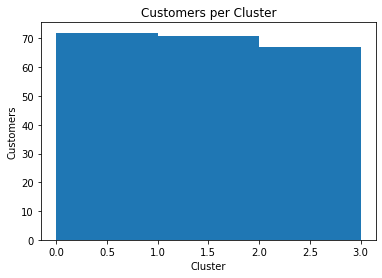

In [591]:
# Custumers per cluster
from sklearn.cluster import KMeans

n_clusters = 3

clustering = KMeans(n_clusters=n_clusters, random_state=0)

cluster_labels = clustering.fit_predict(df_std)

# plot cluster sizes

plt.hist(cluster_labels, bins=range(n_clusters+1))
plt.title ('Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Customers')
plt.show()

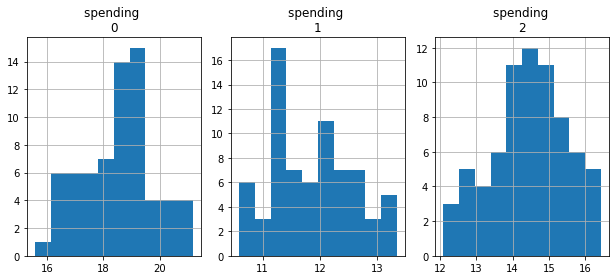

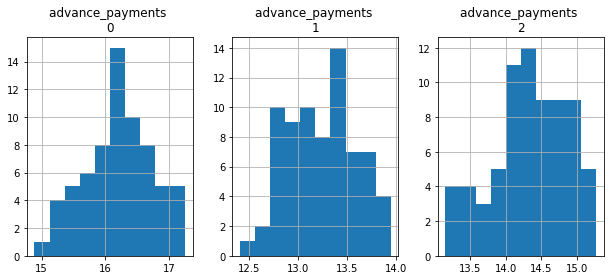

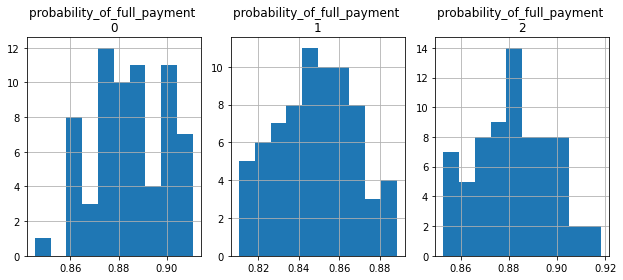

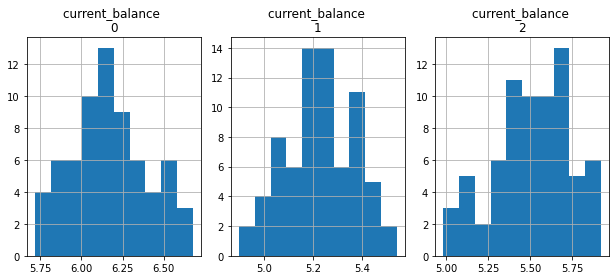

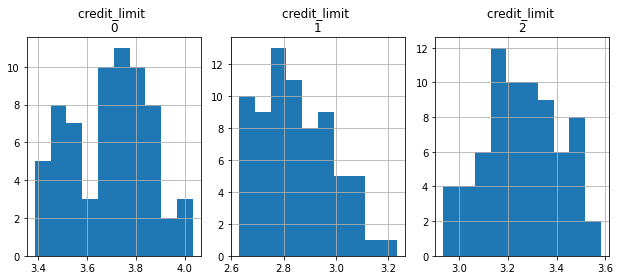

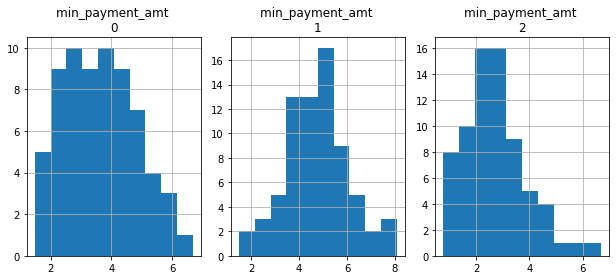

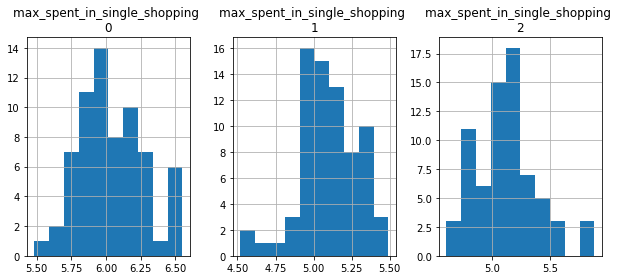

In [592]:
col_list= ['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping']


for column in col_list:
    plt.figure(figsize=(20,4))
    for i in range(0,3):
        plt.subplot(1,7,i+1)
        cluster = df1[df1['KM3_cluster']==i]
        cluster[column].hist()
        plt.title('{} \n{}'.format(column, i))
        
    plt.tight_layout()
    plt.show()

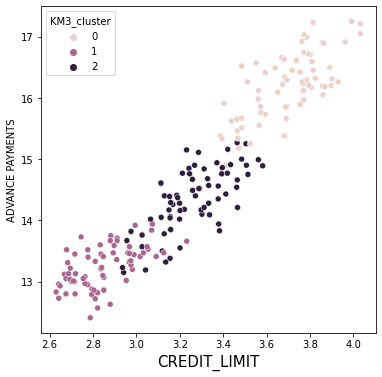

In [593]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='credit_limit', y='advance_payments', hue='KM3_cluster',data=df1);
plt.xlabel('CREDIT_LIMIT',size=15)
#plt.xlim([0,40000])
plt.ylabel('ADVANCE PAYMENTS', size =10);

<Figure size 1800x1800 with 0 Axes>

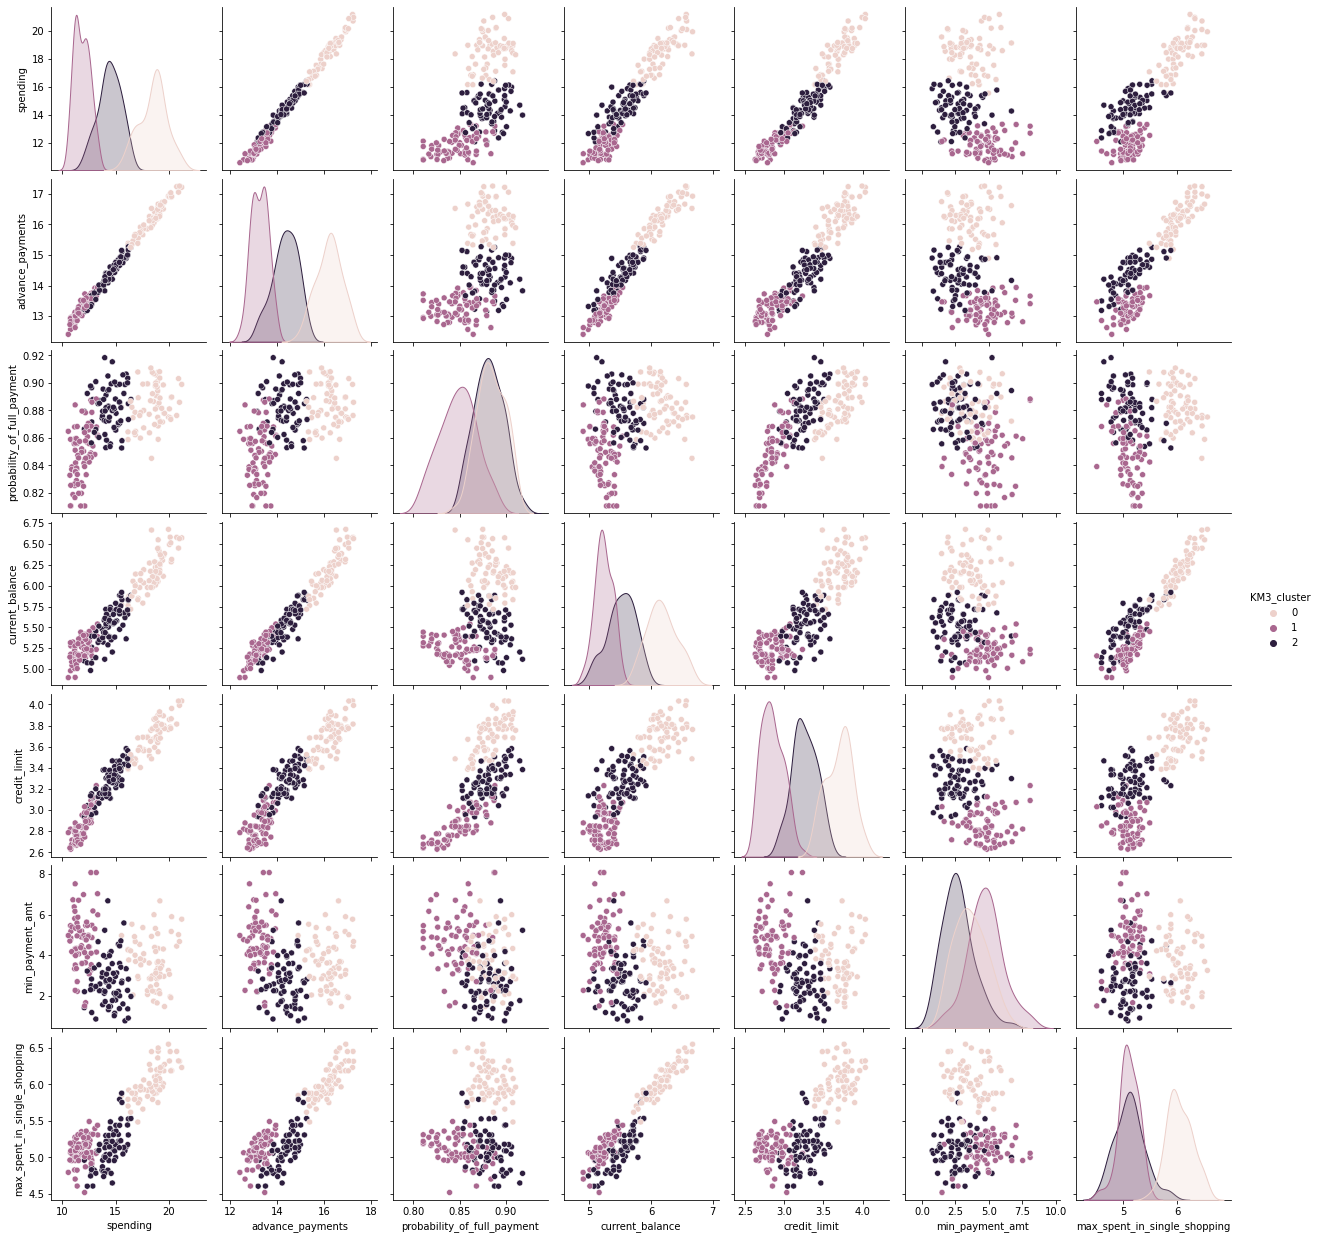

In [594]:
best_columns = ['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping']

best_columns.append("KM3_cluster")
plt.figure(figsize=(25,25))
sns.pairplot( df1[best_columns], hue="KM3_cluster");

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


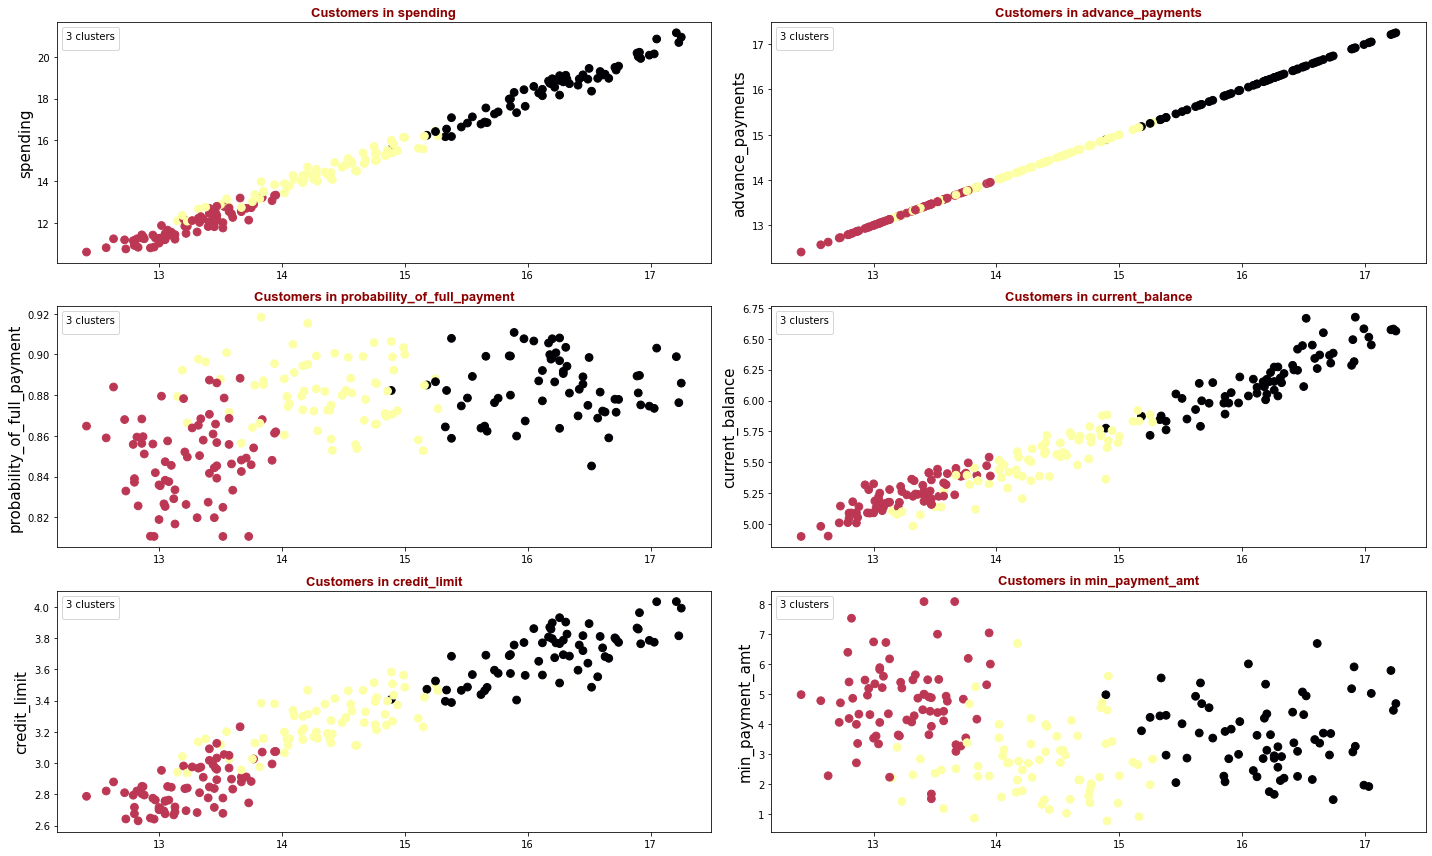

In [595]:
fig, axes = plt.subplots(3,2,figsize=(20,12))
title_font = {'family': 'arial', 'color': 'darkred','weight': 'bold','size': 14 }

for i in range(0,6):
    
    plt.subplot(3, 2, i+1)
    plt.scatter(df1['advance_payments'], df1[best_columns[i]], c= df1['KM3_cluster'], s=60, cmap='inferno')
    legend = plt.legend(title='3 clusters', loc="upper left")
    plt.title('Customers in '+ str(best_columns[i]), fontdict=title_font, fontsize=13)
    #plt.xlabel('customer_behaviours',size=15)
    plt.ylabel(str(best_columns[i]),size=15)
    

plt.tight_layout()
plt.show()

Indicated: Customers with small, medium, and large spending, advance payments, and credit limit.
Low spenders make a higher minimum payment. A customer segment indicated in black has credit limit way lower in comparison with their spending and advance payments.
Probability of full payment is higher for black group.

In [596]:
# Kmeans Model with 3 Clusters

In [597]:
kmeans3  = KMeans(n_clusters=3, random_state=1).fit(df_std)
df1['cluster'] = kmeans3.labels_

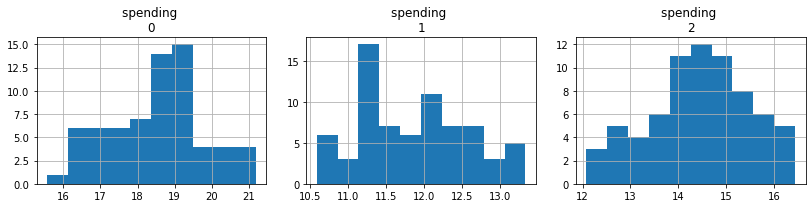

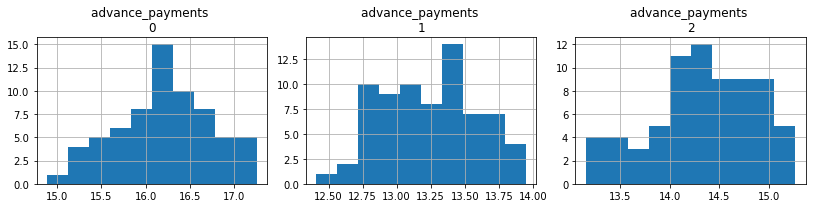

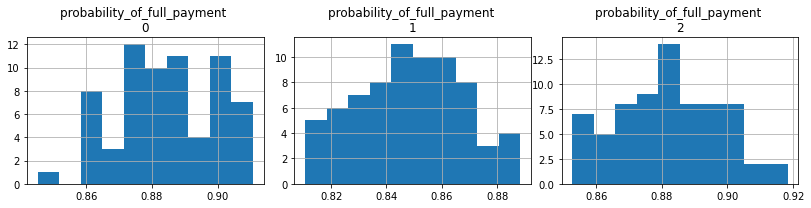

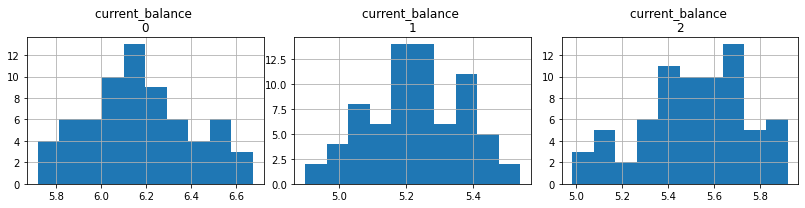

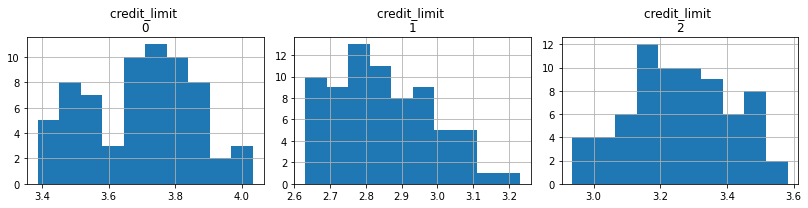

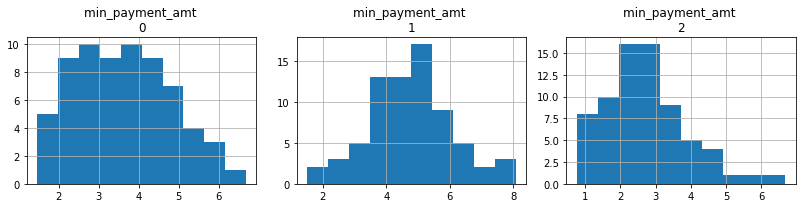

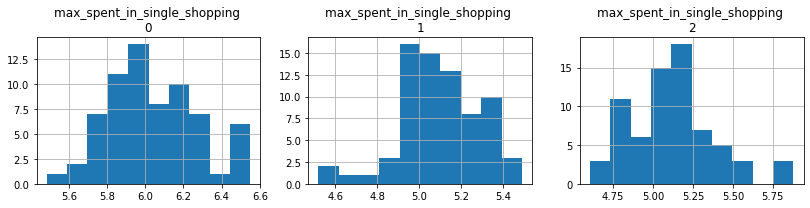

In [598]:
col_list= ['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping']


for column in col_list:
    plt.figure(figsize=(15,3))
    for i in range(0,3):
        plt.subplot(1,4,i+1)
        cluster = df1[df1['cluster']==i]
        cluster[column].hist()
        plt.title('{} \n{}'.format(column, i))
        
    plt.tight_layout()
    plt.show()

<Figure size 1800x1800 with 0 Axes>

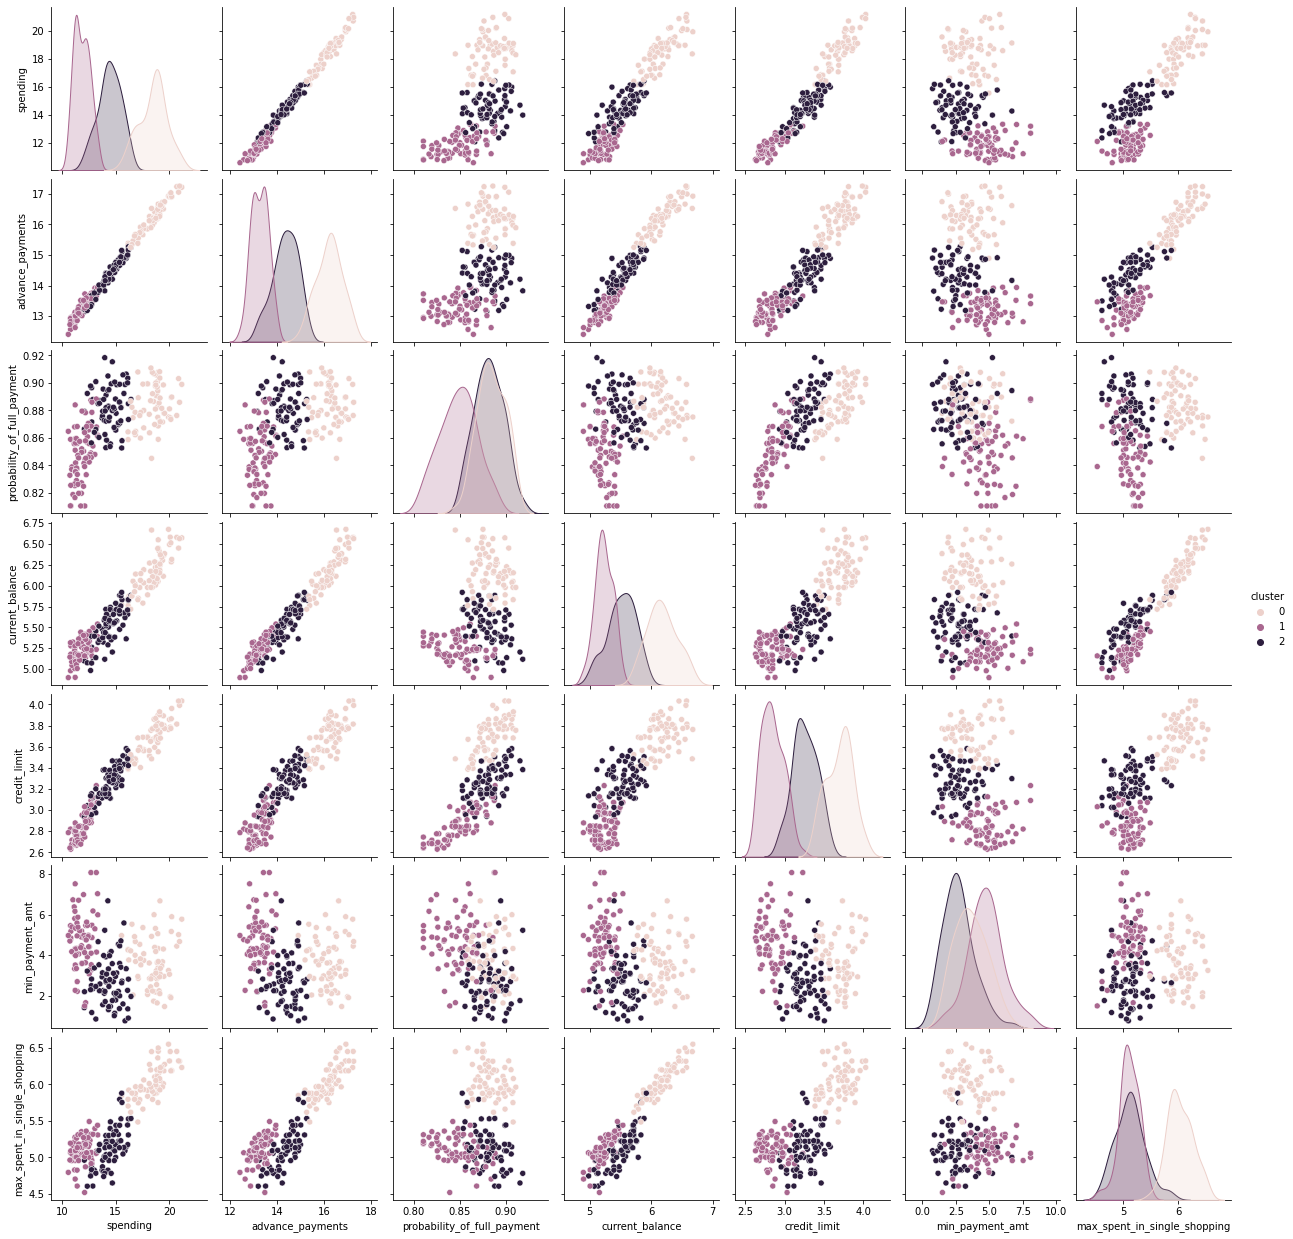

In [599]:
best_columns = ['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping']

best_columns.append("cluster")
plt.figure(figsize=(25,25))
sns.pairplot( df1[best_columns], hue="cluster");

# Cluster details

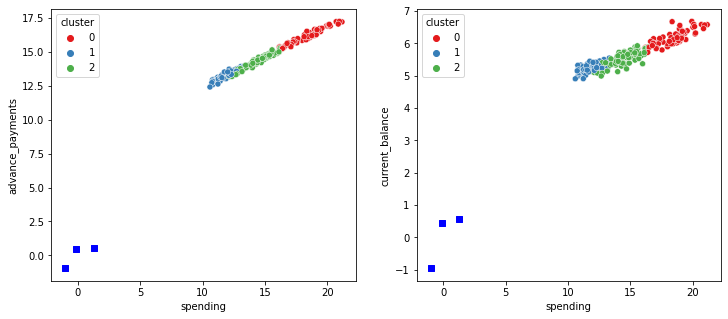

In [600]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('spending', 'advance_payments', data=df1,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('spending', 'current_balance', data=df1,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(kmeans3.cluster_centers_[:,1],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(kmeans3.cluster_centers_[:,0],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

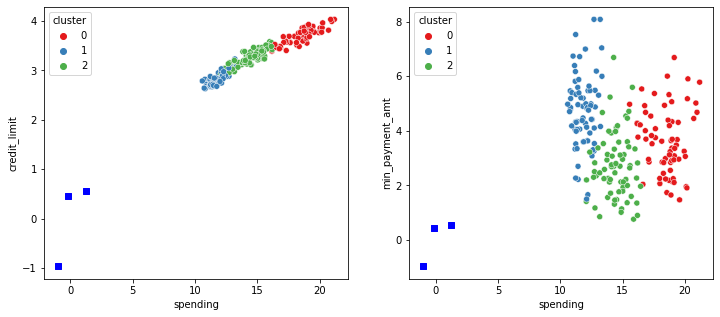

In [601]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('spending', 'credit_limit', data=df1,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('spending', 'min_payment_amt', data=df1,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(kmeans3.cluster_centers_[:,1],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(kmeans3.cluster_centers_[:,0],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

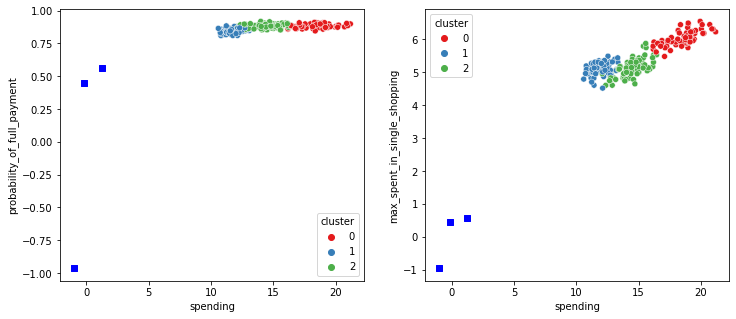

In [602]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('spending', 'probability_of_full_payment', data=df1,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('spending', 'max_spent_in_single_shopping', data=df1,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(kmeans3.cluster_centers_[:,1],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(kmeans3.cluster_centers_[:,0],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

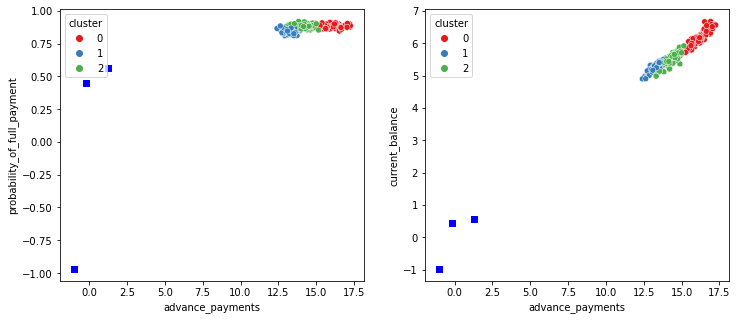

In [603]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('advance_payments', 'probability_of_full_payment', data=df1,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('advance_payments', 'current_balance', data=df1,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(kmeans3.cluster_centers_[:,1],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(kmeans3.cluster_centers_[:,0],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

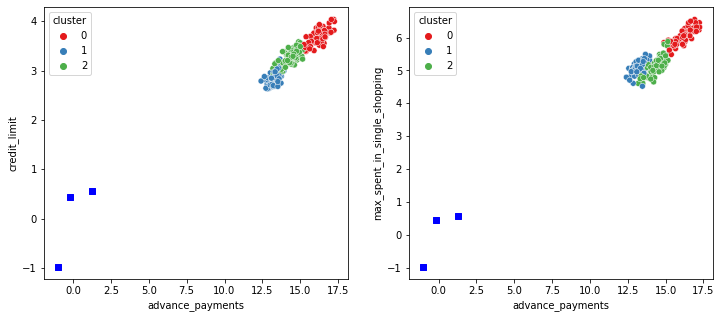

In [604]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('advance_payments', 'credit_limit', data=df1,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('advance_payments', 'max_spent_in_single_shopping', data=df1,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(kmeans3.cluster_centers_[:,1],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(kmeans3.cluster_centers_[:,0],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

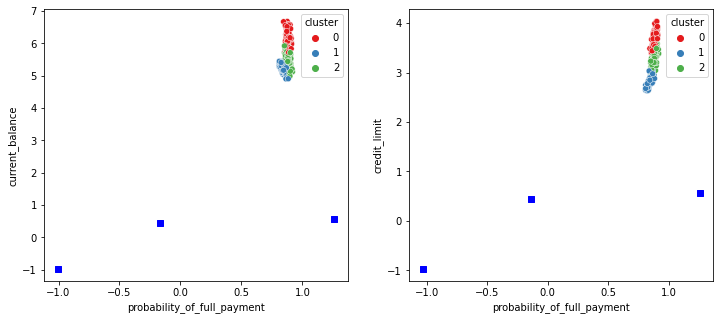

In [605]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('probability_of_full_payment', 'current_balance', data=df1,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('probability_of_full_payment', 'credit_limit', data=df1,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(kmeans3.cluster_centers_[:,1],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(kmeans3.cluster_centers_[:,0],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

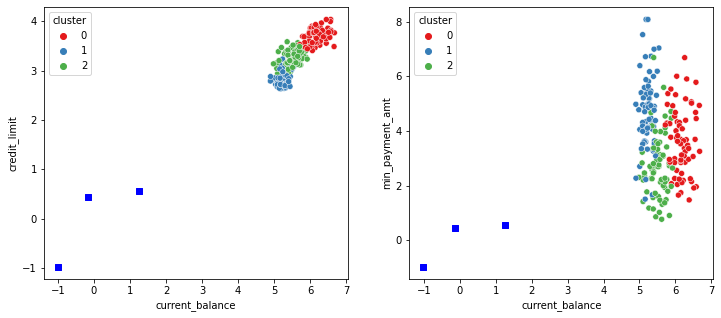

In [606]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('current_balance', 'credit_limit', data=df1,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('current_balance', 'min_payment_amt', data=df1,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(kmeans3.cluster_centers_[:,1],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(kmeans3.cluster_centers_[:,0],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

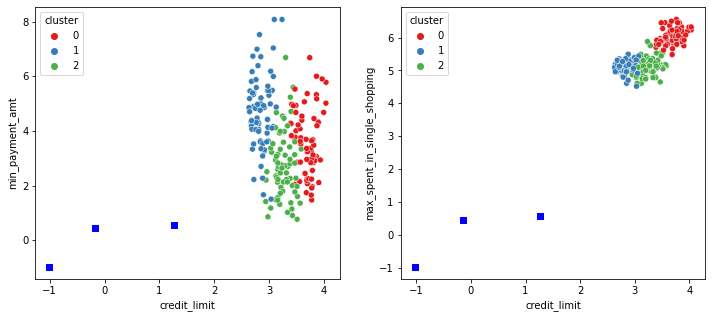

In [607]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('credit_limit', 'min_payment_amt', data=df1,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('credit_limit', 'max_spent_in_single_shopping', data=df1,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(kmeans3.cluster_centers_[:,1],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(kmeans3.cluster_centers_[:,0],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

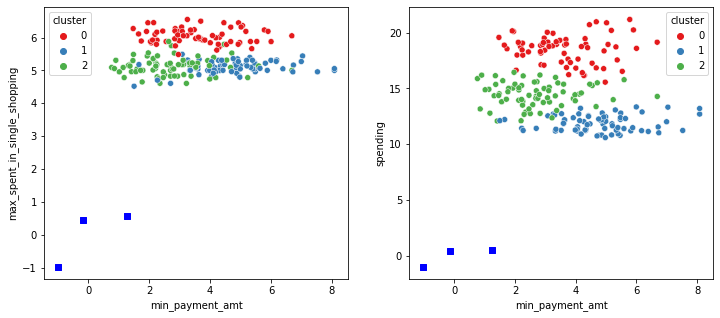

In [608]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('min_payment_amt', 'max_spent_in_single_shopping', data=df1,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('min_payment_amt', 'spending', data=df1,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(kmeans3.cluster_centers_[:,1],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(kmeans3.cluster_centers_[:,0],kmeans3.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

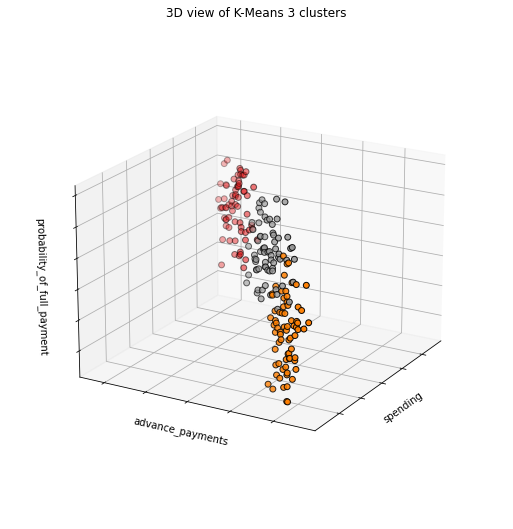

In [609]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(df1['spending'],
           df1['advance_payments'],
           df1['probability_of_full_payment'],
           c=df1['cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('spending')
ax.set_ylabel('advance_payments')
ax.set_zlabel('probability_of_full_payment')
ax.set_title('3D view of K-Means 3 clusters')
ax.dist = 12

plt.show()

In [611]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['cluster']==n]['spending'],
        y = db[db['cluster']==n]['advance_payments'],
        z = db[db['cluster']==n]['probability_of_full_payment'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(df1, 0, 'Cluster 0')
trace1 = tracer(df1, 1, 'Cluster 1')
trace2 = tracer(df1, 2, 'Cluster 2')

data = [trace0, trace1, trace2]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'spending'),
            yaxis = dict(title = 'advance_payments'),
            zaxis = dict(title = 'probability_of_full_payment')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

# Conclusion

After executing various methods, we choose Kmeans, since the data does not include different small groups but very similar to each other. For record sake, we did try out density-based algorithms but, one, it was out of the scope of this project, and two, we did not prefer to use those based on the results. Those algorithms, though, can help us seek out extreme customers in credit card fraud. This study aims customer segmentation by using customer behaviour.

Compering 2 different Kmeans models showed that we have a better understanding of customer segmentation by using the 3-cluster model. Some of the outstanding results:

Cluster 1: This customer group indicates a small group of customers who are high spenders with high advance payment. We can also assume that this customer segment uses its credit card as a loan. They may want the bank to increase their credit limits so that they are able to keep their spending habits.

Cluster 2: These customers purchase frequently but use their credit cards for a small number of purchases.

Cluster 3: This segment points out new or low-spending customers with a lower credit limit and current balance. It is a similar customer segment as cluster 2 but with a lower average spending.